<a href="https://colab.research.google.com/github/jojoroy/Data-Science/blob/main/GPMH_LotkaVolterra_sims.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Building some intuition about the $L^2$ based risk approach.

The general idea is the following:  we employ a surrogate GP model for the log likelihood of a positive density $\pi$, i.e.
we assume that
$$
    \pi_f(x) = \frac{\exp(f(x))\pi_0(x)}{\int \exp(f(x'))\pi_0(x')\,dx'}.
$$
where $\pi_0$ is a prior distribution which is assumed to be tractable.   We denote by $\widetilde{\pi}_f$ to be the unnormalised posterior distribution.

#### Approach 1:  $L^2$ between unnormalised measures loss.

This is the idea of [Sinsbeck and Nowak](https://epubs.siam.org/doi/abs/10.1137/15M1047659), however it has been adjusted to make it comparable to our approach.  While in their paper they considered a surrogate for the actual forward problem, in this work we surrogate the likelihood directly.   This is directly discussed in [Jarvenpaa et al, 2021](https://projecteuclid.org/journals/bayesian-analysis/volume-16/issue-1/Parallel-Gaussian-Process-Surrogate-Bayesian-Inference-with-Noisy-Likelihood-Evaluations/10.1214/20-BA1200.full), although the focus of that paper is an alternative loss function.   

We wish to derive an optimal estimator for the unnormalised posterior $\widetilde{\pi}_f$ using Bayesian decision theory.  To this end, we consider the integrated quadratic loss function:
$$
    l(\widetilde{\pi}_1, \widetilde{\pi}_2) = \int_{X} |\widetilde{\pi}_1(x) - \widetilde{\pi}_2(x)|^2\,dx,
$$
where we assume that both $\widetilde{\pi}_1$ and $\widetilde{\pi}_2$ are square-integrable.

The optimal bayes estimator is the minimiser of the expected loss, i.e.
$$
\begin{aligned}
    \widetilde{\pi}^* &= \arg\min_{d} \mathbb{E}_{f| D} \int |\widetilde{\pi}_f(x) - d(x)|^2\,dx \\
                      &= \arg\min_{d}  \int \mathbb{E}_{f| D} |\widetilde{\pi}_f(x) - d(x)|^2\,dx
\end{aligned}
$$
The optimal estimator can be derived and shown to be
$$
    \widetilde{\pi}^* =  \mathbb{E}_{f| D}[\widetilde{\pi}_f].
$$

The Bayes risk is the integrated variance;
$$
\int {Var}_{f | D}[\widetilde{\pi}_f(x)]\,dx.
$$

You can derive closed-form expressions for both in the GP case, namely
$$
   \mathbb{E}_{f| D}[\widetilde{\pi}_f] = \pi_0(x)e^{m(x) + s^2(x)},
$$
and
$$
 {Var}_{f | D}[\widetilde{\pi}_f(x)] = \pi_0(x)^2 e^{2m(x) + s^2(x)}(e^{s^2(x)} - 1),
$$
where $m$ and $s$ are the pointwise mean and standard deviation of the conditioned GP $f | D$.  

### Our Proposed Approach

We propose the following iterative scheme

Find $p_n$ such that
$$
    \arg\max_{x} \mathbb{E}_{z \sim f(x)|D}\mathbb{E}_{f|D }D(p_{D \cup \lbrace (x,y)\rbrace } \,|\, p_{D})
$$
Choosing KL divergence we have objective function
$$
\mathbb{E}_{z \sim f(x)|D} \mathbb{E}_{f|D }\int \frac{e^{f_n(x) - k_n(x,x^*)k_n(x^*, x^*)^{-1}z)}}{\int e^{f_n(x') - k_n(x',x^*)k_n(x^*, x^*)^{-1}z)}\,dx'}k_n(x,x^*)k_n(x^*, x^*)^{-1}z\,dx.
$$

With Fisher divergence, we get a similar expression, but with gradients in the integrand.   If we can argue that we can replace $f$ with it's mean, then this simplifies somewhat:
$$
\mathbb{E}_{z \sim f(x)|D} \int \frac{e^{m_n(x) - k_n(x,x^*)k_n(x^*, x^*)^{-1}z)}}{\int e^{m_n(x') - k_n(x',x^*)k_n(x^*, x^*)^{-1}z)}\,dx'}k_n(x,x^*)k_n(x^*, x^*)^{-1}z\,dx.
$$
It is unclear how we can justify this assumption, and further how to cleanly deal with the expectation wrt to $z$.

### Exploring the $L^2$ loss based estimator and its risk.   

We implement the idea of Sinsbeck and Nowak, but adjust it to work in our setting where we have a surrogate for the likelihood directly.

In [1]:
pip install jaxtyping


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.3 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.3.1 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [2]:
pip install gpjax==0.8.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.6/111.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.1/819.1 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.2/197.2 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 2.8 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-probability
    Found existing installation: tensorflow-probability 0.24.0
    Uninstalling tensorflow-probability-0.24.0:
      Successfully uninstalled tensorflow-probability-0.24.0
  Attempting uninstall: optax
    Found existing installation: optax 0.2.2
    Uninstalling optax-0.2.2:
      Successfully uninstalled optax-0.2.2


In [3]:
# Enable Float64 for more stable matrix inversions.
from jax import config

config.update("jax_enable_x64", True)

from jax import jit
import jax.numpy as jnp
import jax.random as jr
from jaxtyping import install_import_hook
import matplotlib as mpl
import matplotlib.pyplot as plt
import optax as ox

with install_import_hook("gpjax", "beartype.beartype"):
    import gpjax as gpx

from jax.scipy.special import logsumexp
from jax.scipy.stats import norm as norm
import cola


key = jr.PRNGKey(123)

/usr/local/lib/python3.10/dist-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


In [4]:
import numpy as np
#from jax.scipy.special import log1p

This is just some test code to check that the Gaussian process does regression properly.

In [5]:
kernel = gpx.kernels.RBF()
meanf = gpx.mean_functions.Zero()
prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)

In [6]:
# Define the negative log marginal likelihood
negative_mll = gpx.objectives.ConjugateMLL(negative=True)
negative_mll = jit(negative_mll)
#from gpjax.parameters import Static

def fit_gp(x,y, key, do_optimize=True, obs_stddev=1e-3):
    """Fit a GP to the data (x,y) using the negative log marginal likelihood as the objective function.
    Args:
        x: input data
        y: output data
        key: random key
        do_optimize: whether to optimize the hyperparameters
        obs_stddev: observation noise
    Returns:
        posterior: the posterior distribution
    """

    D = gpx.Dataset(x, y)

    kernel = gpx.kernels.RBF()
    meanf = gpx.mean_functions.Zero()
    prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)

    likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n,obs_stddev=jnp.array(1e-3))  # Our function is noise-free, so we set the observation noise's standard deviation to a very small value
    likelihood = likelihood.replace_trainable(obs_stddev=False)
    posterior = prior * likelihood
    '''suggestion:<300 points reestimate hyperparameters else every 10'''
    if do_optimize:
        # optimize the hyperparameters using Adam (this isn't great, but it works)
        # TODO: use a better optimizer
        # the optimizer needs optax to work
        opt_posterior, a = gpx.fit(
        model=posterior,
        objective= negative_mll,
        num_iters=1000,
        train_data=D,
        optim=ox.adamw(learning_rate=0.01),safe=True,
        key = key)

        return opt_posterior
    else:
        return posterior


def evaluate_posterior(x,y, x_eval, key, do_optimize=True, obs_stddev=1e-3):
    """Evaluate the posterior predictive distribution at x_eval.
    Args:
        x: input data
        y: output data
        x_eval: points at which to evaluate the posterior predictive distribution
        do_optimize: whether to optimize the hyperparameters
        obs_stddev: observation noise
    Returns:
        predictive_mean: mean of the posterior predictive distribution
        predictive_std: standard deviation of the posterior predictive distribution
    """

    D = gpx.Dataset(x, y)

    posterior = fit_gp(x,y, key, do_optimize=do_optimize, obs_stddev=obs_stddev)


    latent_dist = posterior.predict(x_eval, train_data=D)
    predictive_dist = posterior.likelihood(latent_dist)

    predictive_mean = predictive_dist.mean()
    predictive_std = predictive_dist.stddev()

    return predictive_mean, predictive_std

To select a new point, Sinsbeck and Nowak make use of the L2 risk function (also Jarvenpaa et al, 2021), as follows:

$$
    R(\theta^*) = \mathbb{E}_{y \sim f(x^*) |D}\int e^{2m_t(x; x^*, y) + s_t^2(x; x^*, y)}(e^{s_t^2(x; x^*, y)} - 1),
$$
where $m_t(x; x^*, y)$ is the posterior mean of the GP after conditioning on the current data set $D$ along with an additional point $(x^*, y)$.  The variance $s_t^2(x; x^*, y)$ is defined analogously.

To compute the expectation, we do Monte Carlo using exact samples of $y \sim f(x^*) |D$.  We typically use just $10$ samples.  Unsurprisingly this is very slow, and little bit unstable.

To compute the integral over $x$, we evaluate the gp over a fine mesh and use Euler integration.   This obviously cannot scale beyond a few dimensions.

So can we avoid the need to compute the expectation with respect to y?   

To do so, we follow the approach / derivations in [Jarvenpaa, 2021] which derive closed form distributions for the GP mean and GP variance.  

More specifically we can show that the loss function becomes
$$
        R(\theta^*) = \int e^{2m_t(x) + s_t^2(x)}(e^{\tau_t(x, x^*)} - 1),
$$
where
$$
\tau_t(x, x^*) = \frac{k_t(x, x^*)^2}{s_t(x^*)^2 + \sigma^2},
$$
where $\sigma^2$ is the variance of the observational noise and where

* $k_t$ is the kernel (i.e. two-point covariance) of the GP conditioned on $D$.
* $m_t$ is the mean of the GP conditioned on $D$.
* $s_t^2$ is the variance of the GP conditioned on $D$.

In [7]:
# this computes k_t, the two point covariance function
def two_point_covariance(x_current, X, Y, posterior, jitter=1e-6):
    """Compute the two point covariance function.
    Args:
        x_current: current point
        X: input data
        Y: output data
        posterior: posterior distribution
        jitter: jitter for numerical stability
    Returns:
        covariance: two point covariance function
    """
    kernel = posterior.prior.kernel
    obs_noise = posterior.likelihood.obs_stddev**2

    Kxx = kernel.gram(x_current)
    Kxx += cola.ops.I_like(Kxx) * obs_noise

    #Sigma = Kxx + cola.ops.I_like(Kxx) * obs_noise
    #Sigma = cola.PSD(Sigma)

    KXY = kernel.cross_covariance(X, Y)
    KXx = kernel.cross_covariance(X, x_current)
    KxY = kernel.cross_covariance(x_current, Y)


    Sigma_inv_KxY = cola.solve(Kxx, KxY)

    covariance = KXY - jnp.matmul(KXx, Sigma_inv_KxY)

    return covariance

How do we interpret the loss function?

1. The $\mu_n$ weights points which have mean (exploitation)
2. The $\sigma_n^2$ weights points which have higher absolute variance (exploration).
3. The main term $\tau^2(a,b)$ is large when there's a strong correlation between $a$ and $b$, weighted by their standard deviation.

The tau effectively acts as a "bump" function which aggregates points around the design point.

In summary -- preferred design points will lie in a neighbourhood of large $\mu_n$ or large $\sigma^2_n$, thus effectively performing exploration / exploitation.

### Computational Cost

Every macro step of the algorithm is $O(N^3)$, where $N$ is the number of points evaluated
Within each macro-step you have cost $M*N^2$, where $M$ is the number of MCMC samples generated.

## 2023 paper

In [8]:
# This removes the terms that don't depend on x_new
def loss_2023paper(x_current, y_current, x_new, x_grid, key, obs_stddev=1e-3):
    """Evaluate the L2 risk function at x_new.
    The code is vectorised over x_new, so you can just pass in a full grid of test points to evaluate it at

    This version removes the terms that don't depend on x_new, so it's faster than loss_fast.
    Args:
        x_current: input data
        y_current: output data
        x_new: point(s) at which to evaluate the risk function
        x_grid: points at which to evaluate the posterior predictive distribution
        key: random key
        obs_stddev: observation noise
    Returns:
        risk_value: risk function value
    """
    D = gpx.Dataset(x_current, y_current)

    posterior = fit_gp(x_current, y_current, key, do_optimize=True, obs_stddev=obs_stddev)

    latent_dist = posterior.predict(x_new, train_data=D)
    predictive_dist = posterior.likelihood(latent_dist)

    p_mean = predictive_dist.mean()#.reshape(-1,1)
    p_std = predictive_dist.stddev()#.reshape(-1,1)

    C = two_point_covariance(x_current, x_grid, x_new, posterior)
    #print(np.shape(C))


    tau2 = (C[0]-C[1])**2/(p_std**2 + obs_stddev**2)
    # utility_value =  jnp.mean(jnp.exp(2.0*p_mean**2 + p_std**2 - offset)*(jnp.exp(p_std**2) - jnp.exp(tau2)), axis=0)

    #log_loss = -logsumexp(2.0*p_mean + p_std**2 + tau2, axis=0)

    #return(log_loss)
    #print(np.shape(tau2))
    return(tau2)

In [9]:
# This removes the terms that don't depend on x_new
def loss_2023papernew(posterior,x_current, y_current, x_new, x_grid, key, obs_stddev=1e-3):
    """Evaluate the L2 risk function at x_new.
    The code is vectorised over x_new, so you can just pass in a full grid of test points to evaluate it at

    This version removes the terms that don't depend on x_new, so it's faster than loss_fast.
    Args:
        x_current: input data
        y_current: output data
        x_new: point(s) at which to evaluate the risk function
        x_grid: points at which to evaluate the posterior predictive distribution
        key: random key
        obs_stddev: observation noise
    Returns:
        risk_value: risk function value
    """
    #D = gpx.Dataset(x_current, y_current)

    #posterior = fit_gp(x_current, y_current, key, do_optimize=True, obs_stddev=obs_stddev)

    latent_dist = posterior.predict(x_new, train_data=D)
    predictive_dist = posterior.likelihood(latent_dist)

    p_mean = predictive_dist.mean()#.reshape(-1,1)
    p_std = predictive_dist.stddev()#.reshape(-1,1)

    C = two_point_covariance(x_current, x_grid, x_new, posterior)
    #print(np.shape(C))


    tau2 = (C[0]-C[1])**2/(p_std**2 + obs_stddev**2)
    # utility_value =  jnp.mean(jnp.exp(2.0*p_mean**2 + p_std**2 - offset)*(jnp.exp(p_std**2) - jnp.exp(tau2)), axis=0)

    #log_loss = -logsumexp(2.0*p_mean + p_std**2 + tau2, axis=0)

    #return(log_loss)
    #print(np.shape(tau2))
    return(tau2)

In [10]:
def epsilon_gamma(m,v,u):
  return norm.cdf(-jnp.abs(m-jnp.log(u)/jnp.sqrt(v)))

In [11]:
def log_epsilon_gamma(m,v,u):
  return norm.logcdf(-jnp.abs(m-jnp.log(u)/jnp.sqrt(v)))

In [12]:
#PRONE TO INSTABILITY
def expected(m,v):
  v1=np.sqrt(v)
  if m>=0:
    return norm.cdf(-m/v1)-jnp.exp(m+(v/2))*norm.cdf(-(m/v1+v1))
  else:
    return norm.cdf(m/v1)+jnp.exp(m+(v/2))*(norm.cdf(-(m/v1+v1))-2*norm.cdf(-v1))

In [13]:
def expected1(m,v):
  u = jnp.arange(0,1,0.05)
  return logsumexp(log_epsilon_gamma(m,v,u))

In [14]:
#make new eval posterior for this situation
def gpmh_eval_posterior1(posterior,x_prop,x_now,key,obs_stddev, D):
  x_eval = jnp.vstack([x_now,x_prop])

  x_eval = x_eval.reshape(-1,1)
  #D = gpx.Dataset(x_current, y_current)

  #posterior = fit_gp(x_current, y_current, key, do_optimize=False, obs_stddev=obs_stddev)

  latent_dist = posterior.predict(x_eval, train_data=D)
  predictive_dist = posterior.likelihood(latent_dist)
  m = predictive_dist.mean().reshape(-1,1)
  v = predictive_dist.stddev().reshape(-1,1)
  C = two_point_covariance(x_current, x_eval[0].reshape(-1,1), x_eval[1].reshape(-1,1), posterior)
  #print(m,x_eval)
  return m[1]-m[0],v[0]**2 + v[1]**2 - 2*C

In [15]:
#make new eval posterior for this situation
def gpmh_eval_posterior_2d(posterior,x_current,x_prop,x_now,key,obs_stddev, D):
  x_eval = jnp.vstack((x_now,x_prop))

  #x_eval = x_eval.reshape(-1,1)
  #D = gpx.Dataset(x_current, y_current)

  #posterior = fit_gp(x_current, y_current, key, do_optimize=False, obs_stddev=obs_stddev)
  #print( x_eval[0], x_eval[1],x_current)
  latent_dist = posterior.predict(x_eval, train_data=D)
  predictive_dist = posterior.likelihood(latent_dist)
  m = predictive_dist.mean().reshape(-1,1)
  v = predictive_dist.stddev().reshape(-1,1)
  C = two_point_covariance(x_current, jnp.array([x_eval[0]]), jnp.array([x_eval[1]]), posterior)
  #C1 = two_point_covariance(x_current, jnp.array([x_eval[0]]), jnp.array([x_eval[0]]), posterior)
  #C2= two_point_covariance(x_current, jnp.array([x_eval[1]]), jnp.array([x_eval[1]]), posterior)
  #print(v**2,C,C1,C2,posterior.likelihood.obs_stddev**2)
  #print(m,x_eval)
  return m[1]-m[0],v[0]**2 + v[1]**2 - 2*C-2*posterior.likelihood.obs_stddev**2

# thoughts for likelihood
simulate likelihood for the data given different parameters
choosing new points means choosing new parameters to fit the model
if u want the likelihood to be normal

In [ ]:
from jax import vmap
from jax.experimental.ode import odeint

In [ ]:
def lotka_volterra(X, t, alpha, beta, delta, gamma):
    x, y = X
    dxdt = alpha * x - beta * x * y
    dydt = delta * x * y - gamma * y
    return [dxdt, dydt]

# Vectorized integration function
def integrate_model(params, t, initial_conditions):
    alpha, beta = params
    delta=0.1
    gamma=1.5
    # Define the ODE function for a single set of parameters
    def odefunc(X, t):
        return lotka_volterra(X, t, alpha, beta, delta, gamma)

    # Integrate the ODE
    return odeint(odefunc, initial_conditions, t)

# Vectorized log-likelihood function
@jit
def log_likelihood_lv(params):#, t, data, initial_conditions):
    params=jnp.exp(params)
    # Ensure params are in the correct shape (N, 4) where N is the number of parameter sets
    def integrate_single(params):
        return integrate_model(params, t, initial_conditions)

    # Vectorize integration over parameter sets
    models = vmap(integrate_single)(params)

    # Compute the error and log-likelihood for each parameter set
    errors = data - models

    sigma=10000
    log_likelihoods = -jnp.sum(errors**2, axis=(1, 2)) / (2*sigma) +10.
    return log_likelihoods

# Example data
true_params = jnp.array([2.0, 0.1])
initial_conditions = jnp.array([10.0, 5.0])
t = jnp.linspace(0, 50, 500)
data = integrate_model(true_params, t, initial_conditions)

# Initial guess for parameters
initial_params = jnp.array([[1.0, 0.05], [2.0, 0.1],[1.1,1.1]])

# Compute log-likelihoods for each parameter set
ll_values = log_likelihood_lv(initial_params)#, t, data, initial_conditions)
print("Log-Likelihoods:", ll_values)

Log-Likelihoods: [-11.53813645  -7.59255162 -31.01450342]


In [ ]:
# define x current and y_current
params_current = jnp.array([[1.0, 0.1], [2.0, 0.2], [1.5, 0.3],[0.1,0.1],[2.0,-3.0],[-2.0,-3.0],[-2.0,1.0]])
mean = [0, 0]
cov = [[0.1, 0], [0, 0.1]]

params_current = jnp.array(np.random.multivariate_normal(mean, cov, 20))
params_current = jnp.array(np.random.uniform([-2,-3],[2,1],(30,2)))
params_current=round(params_current,1)
true_params = jnp.array([2.0, 0.1])
initial_conditions = jnp.array([10.0, 5.0])
t = jnp.linspace(0, 50, 500)
#data = generate_synthetic_data(true_params, initial_conditions, t)
y_current = jnp.array(log_likelihood_lv(params_current).reshape(-1,1))
# set up empty mh_samples


In [ ]:
params_current

Array([[-0.9,  0.9],
       [ 1.1, -1.9],
       [-1.7, -1. ],
       [-1.8, -1.4],
       [ 1.7, -2.5],
       [ 0. , -2.7],
       [ 1.4,  0.3],
       [-1.4, -0.5],
       [-1.8,  0.1],
       [ 1.3,  0.2],
       [ 1.4,  0. ],
       [-0.3, -0.2],
       [ 0.4, -0.1],
       [-1.1, -2.7],
       [ 1.3, -2.9],
       [-0.8,  0.4],
       [-1.6, -2.9],
       [-1.8,  0.8],
       [ 1.9, -2.4],
       [-1.7, -1.5],
       [ 1.9, -2.8],
       [ 0.2, -1. ],
       [ 0.6, -1.1],
       [-0.8,  0.1],
       [ 1.3, -1. ],
       [-1.8,  0.5],
       [-0.4, -1.1],
       [ 1.4, -2. ],
       [ 1.6,  0.1],
       [ 0.5, -0. ]], dtype=float64)

In [ ]:
N = 3000
mh_samples=np.zeros((N,2))
mh_samples[0,0]=0.25
mh_samples[0,1]=-0.25
epsilon = 0.25
obs_stddev=1e-3
proposal='uniform'

In [ ]:
from sklearn.metrics import pairwise_distances
def remove_close_rows(arr1, arr2, threshold=1e-6):
    # Compute the distance between each pair of rows
    distances = pairwise_distances(arr1,arr2)
    #print(distances)

    # Check if any distance is below the threshold for each row in arr1
    is_close = jnp.any(distances < threshold, axis=1)

    # Keep rows that are not close to any row in arr2
    result = arr1[~is_close]

    return result



In [ ]:
D = gpx.Dataset(params_current, y_current)
#print(D)
posterior = fit_gp(params_current, y_current, key, do_optimize=True, obs_stddev=obs_stddev)
for i in range(1,N):
  # centred around prev step with var 1
  if proposal == 'uniform':
    params_prop = (np.random.uniform(0,1,2) - 0.5)*0.2 + mh_samples[i-1,:]
  else:
    params_prop=(np.random.normal(0,1,2)*0.25 + mh_samples[i-1])
  u = np.random.uniform()
  params_now=mh_samples[i-1]
  # find mean and variance of log likelihood ratio at proposal and prev point
  m,v = gpmh_eval_posterior_2d(posterior,params_current,params_prop,params_now,key,obs_stddev,D)

  print('step',i,log_epsilon_gamma(m,v,u),expected1(m,v),jnp.log(epsilon),'Current',params_now,'proposed',params_prop)

  while expected(m,v) > epsilon:# and np.size(test_points) >5:
  #while (expected1(m,v) > jnp.log(epsilon) or log_epsilon_gamma(m,v,u)>jnp.log(0.1)) and np.size(params_current) < 400:

    obs_stddev = 1e-3
    num_samples= 10

    #x_grid = jnp.arange(-5.0, 5.0, 0.01).reshape(-1, 1)
    params_grid = jnp.vstack([params_now,params_prop])#.reshape(-1,1)

    # how many do you need to set up
    x_range = jnp.arange(start = -3., stop = 3., step = 0.2 )
    y_range = jnp.arange(start = -3., stop = 3., step = 0.2 )

    x_gridvalues, y_gridvalues = jnp.meshgrid(x_range, y_range)
    test_points = jnp.vstack([x_gridvalues.flatten(), y_gridvalues.flatten()]).T
    '''
    max=round(jnp.max(x_grid),1)
    min=round(jnp.min(x_grid),1)

    #get lengthscale
    ls = posterior.prior.kernel.lengthscale
    print('lengthsxale:',ls)
    test_points = jnp.arange(min-round(5*ls,1), round(ls*5,1), 0.1)
    '''
    test_points=remove_close_rows(test_points,params_current)
    test_points= jnp.round(test_points,1)
    ## this remove points done needs work
    #test_points= jnp.array([testpt for testpt in test_points if testpt not in x_current])
    #test_points= jnp.round(test_points,1)
    #print(np.shape(test_points))
    test_point_utilities = loss_2023papernew(posterior,params_current, y_current, test_points,params_grid, key, obs_stddev)

    j = jnp.argmax(jnp.array(test_point_utilities))
    params_new = test_points[j]
    #y_new = l(x_new)
    params_current = jnp.vstack([params_current, params_new])
    y_current = log_likelihood_lv(params_current).reshape(-1,1)
    D = gpx.Dataset(params_current, y_current)

    posterior = fit_gp(params_current, y_current, key, do_optimize=True, obs_stddev=obs_stddev)
    m,v = gpmh_eval_posterior_2d(posterior,params_current,params_prop,params_now,key,obs_stddev, D)
    print('chosen new point',params_new,'size',np.shape(params_current),jnp.exp(expected1(m,v)))
  print('m',m,'v',v,u)
  if m >= jnp.log(u):
    mh_samples[i] = params_prop
  else:
    mh_samples[i] = mh_samples[i-1]


  0%|          | 0/1000 [00:00<?, ?it/s]

step 1 [[-89.80950231]] -0.44650493845940675 -1.3862943611198906 Current [ 0.25 -0.25] proposed [ 0.22239867 -0.21861991]
m [-0.48759346] v [[0.00543768]] 0.36612052918856985
step 2 [[-244.06742343]] 0.34473637140542646 -1.3862943611198906 Current [ 0.22239867 -0.21861991] proposed [ 0.16433919 -0.1851829 ]
m [-0.45684992] v [[0.02346804]] 0.03249439078307448
step 3 [[-32.8422465]] -0.4080967023394475 -1.3862943611198906 Current [ 0.16433919 -0.1851829 ] proposed [ 0.08015665 -0.19802275]
m [0.59728479] v [[0.07194545]] 0.14768206474524992
step 4 [[-1.89749724]] 1.1974077469841553 -1.3862943611198906 Current [ 0.08015665 -0.19802275] proposed [ 0.17862358 -0.13657167]


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.2 -0.2] size (31, 2) 2.003624810086038


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [0.2 0. ] size (32, 2) 0.32123408105493695
m [-0.58335769] v [[0.00196958]] 0.8926744624790811
step 5 [[-6.519014]] -0.3626635678441804 -1.3862943611198906 Current [ 0.08015665 -0.19802275] proposed [ 0.08624663 -0.28205341]
m [0.06447833] v [[0.01844437]] 0.6736870762429984
step 6 [[-7.16855638]] -1.0840669807237133 -1.3862943611198906 Current [ 0.08624663 -0.28205341] proposed [ 0.00791421 -0.32940622]
m [0.79630239] v [[0.03951529]] 0.6242320969000402
step 7 [[-85.41721939]] -1.318714971477585 -1.3862943611198906 Current [ 0.00791421 -0.32940622] proposed [-0.06007209 -0.3025867 ]
m [0.77676573] v [[0.02522354]] 0.14810973778469827
step 8 [[-44.15220869]] 0.13531136599094484 -1.3862943611198906 Current [-0.06007209 -0.3025867 ] proposed [-0.06597751 -0.23646291]
m [-0.08514592] v [[0.03120784]] 0.1988726044036948
step 9 [[-2.57416029]] 0.3231118348748012 -1.3862943611198906 Current [-0.06597751 -0.23646291] proposed [-0.10275643 -0.14562673]
m [0.0610787] v [[0.0640

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-0.2 -0.2] size (33, 2) 0.5432852874564605
m [0.15072903] v [[0.01505834]] 0.5246298257511515
step 11 [[-4.22047834]] -0.7935956846151733 -1.3862943611198906 Current [-0.02423199 -0.06065716] proposed [ 0.01066703 -0.14892574]
m [0.54020167] v [[0.03021958]] 0.7521913508806852
step 12 [[-31.18681233]] -0.19740657114841387 -1.3862943611198906 Current [ 0.01066703 -0.14892574] proposed [ 0.00792117 -0.2351374 ]
m [0.11911249] v [[0.02788656]] 0.2908405972497049
step 13 [[-0.80661761]] 0.3860011606336534 -1.3862943611198906 Current [ 0.00792117 -0.2351374 ] proposed [-0.05054586 -0.1596233 ]


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [0. 0.] size (34, 2) 1.0058814022205314
m [-1.54038371] v [[0.00586109]] 0.9186439837375864
step 14 [[-65.88327911]] 0.14204109176184598 -1.3862943611198906 Current [ 0.00792117 -0.2351374 ] proposed [-0.06077711 -0.1434087 ]
m [-1.96373569] v [[0.00752556]] 0.3196354210475363
step 15 [[-88.57672167]] -0.001852429423992774 -1.3862943611198906 Current [ 0.00792117 -0.2351374 ] proposed [ 0.02046393 -0.1523861 ]
m [-1.13613036] v [[0.00659071]] 0.3162397071469205
step 16 [[-80.0174719]] -3.2690742359988434 -1.3862943611198906 Current [ 0.02046393 -0.1523861 ] proposed [ 0.04088395 -0.22638838]
m [1.03883965] v [[0.00424086]] 0.4779427417097095
step 17 [[-35.99789994]] -1.7331013202578887 -1.3862943611198906 Current [ 0.04088395 -0.22638838] proposed [ 0.06900202 -0.30781531]
m [0.75311256] v [[0.01268302]] 0.4361849051242215
step 18 [[-312.09574448]] -1.0728312001187967 -1.3862943611198906 Current [ 0.06900202 -0.30781531] proposed [ 0.1202197 -0.386565 ]
m [0.28164216] 

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.6 -1. ] size (35, 2) 2.4024487109528465


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.8 -0.4] size (36, 2) 0.475033384327108
m [0.08800956] v [[0.01063109]] 0.46296420438698593
step 57 [[-1.22802812]] -0.9008359381994842 -1.3862943611198906 Current [ 0.69318979 -0.73135105] proposed [ 0.72684784 -0.67838473]
m [-0.00722857] v [[0.00695117]] 0.9550008230479091
step 58 [[-402.17595683]] -1.170901756974857 -1.3862943611198906 Current [ 0.72684784 -0.67838473] proposed [ 0.72571715 -0.73681108]
m [0.1566905] v [[0.00672318]] 0.1002315641558792
step 59 [[-97.36032248]] -0.9968906014324705 -1.3862943611198906 Current [ 0.72571715 -0.73681108] proposed [ 0.73242692 -0.78287283]
m [-0.06744633] v [[0.0054268]] 0.3627420819554563
step 60 [[-2.18717245]] 0.46009002782279573 -1.3862943611198906 Current [ 0.73242692 -0.78287283] proposed [ 0.74110088 -0.86723508]


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.6 -0.6] size (37, 2) 0.5659034692883347
m [0.06535691] v [[0.01323069]] 0.7506903356865322
step 61 [[-9.69723609]] 0.6235446798976849 -1.3862943611198906 Current [ 0.74110088 -0.86723508] proposed [ 0.66392918 -0.85804105]
m [-0.16537804] v [[0.06685872]] 0.35496401625351537
step 62 [[-346.82220435]] -0.5119044803575815 -1.3862943611198906 Current [ 0.66392918 -0.85804105] proposed [ 0.70001785 -0.88131064]
m [0.11556547] v [[0.01624721]] 0.03608049133341029
step 63 [[-2.21431014]] 1.0013005840888067 -1.3862943611198906 Current [ 0.70001785 -0.88131064] proposed [ 0.60036185 -0.80839771]


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.8 -1. ] size (38, 2) 0.9120034263680967
m [-0.82989507] v [[0.00689114]] 0.5891374003352181
step 64 [[-127.03215]] -0.37522193632789425 -1.3862943611198906 Current [ 0.70001785 -0.88131064] proposed [ 0.65216575 -0.97251189]
m [-0.25574273] v [[0.00919366]] 0.2164131161469397
step 65 [[-102.07318399]] -0.44506944218527955 -1.3862943611198906 Current [ 0.65216575 -0.97251189] proposed [ 0.68003613 -1.04084468]
m [0.02166938] v [[0.01462872]] 0.18359043921960327
step 66 [[-354.34962978]] -1.5708700120669283 -1.3862943611198906 Current [ 0.68003613 -1.04084468] proposed [ 0.76413469 -1.00307571]
m [0.31877582] v [[0.00564142]] 0.14033810927304324
step 67 [[-1.84962776]] 0.1963665941485121 -1.3862943611198906 Current [ 0.76413469 -1.00307571] proposed [ 0.77845366 -1.0616321 ]
m [-0.48718064] v [[0.01665352]] 0.8247742249106004
step 68 [[-1.01162163]] 0.5766215636195278 -1.3862943611198906 Current [ 0.76413469 -1.00307571] proposed [ 0.70248092 -1.08571916]


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.8 -1.2] size (39, 2) 0.04904739832189239
m [0.71052925] v [[0.00275323]] 0.8471365175443358
step 69 [[-81.87458379]] -0.36673937387138444 -1.3862943611198906 Current [ 0.70248092 -1.08571916] proposed [ 0.60345513 -1.0939071 ]
m [-0.27649368] v [[0.00895028]] 0.2979065610905348
step 70 [[-2.15674689]] -0.6953047490094539 -1.3862943611198906 Current [ 0.60345513 -1.0939071 ] proposed [ 0.60106874 -1.04923277]
m [-0.60444615] v [[0.00321204]] 0.9029547133297777
step 71 [[-8.35712284]] 0.2847866601960919 -1.3862943611198906 Current [ 0.60345513 -1.0939071 ] proposed [ 0.52719388 -1.07811075]
m [-0.91032617] v [[0.01287705]] 0.606409145695459
step 72 [[-7.73970568]] -1.1557493515294772 -1.3862943611198906 Current [ 0.60345513 -1.0939071 ] proposed [ 0.56677727 -1.16145827]
m [0.63418621] v [[0.02171332]] 0.6722341665363454
step 73 [[-0.72938079]] 0.549298476495853 -1.3862943611198906 Current [ 0.56677727 -1.16145827] proposed [ 0.47704491 -1.19649864]
m [-0.20344602] v

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.2 -1.2] size (40, 2) 1.0240259494759867
m [-0.54521768] v [[0.01082323]] 0.7472136616291298
step 96 [[-202.55629746]] -0.4239248258330407 -1.3862943611198906 Current [ 0.45424834 -1.32795171] proposed [ 0.37258995 -1.36899419]
m [-0.11178301] v [[0.01136566]] 0.11802411775498445
step 97 [[-1.05993918]] -0.10896941876678956 -1.3862943611198906 Current [ 0.37258995 -1.36899419] proposed [ 0.34986803 -1.33051711]
m [-0.45937577] v [[0.00953577]] 0.993718764515384
step 98 [[-24.0951146]] 0.9046266324502492 -1.3862943611198906 Current [ 0.37258995 -1.36899419] proposed [ 0.3084683  -1.28597124]
m [-1.47234989] v [[0.05324611]] 0.15801448764131443
step 99 [[-7.81379362]] -1.65345198021677 -1.3862943611198906 Current [ 0.3084683  -1.28597124] proposed [ 0.30722855 -1.34178293]
m [0.74602931] v [[0.01392984]] 0.7354095211338961
step 100 [[-14.15069352]] 0.2556853208195239 -1.3862943611198906 Current [ 0.30722855 -1.34178293] proposed [ 0.39324781 -1.25667729]
m [-0.2586949

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.8 -1.6] size (41, 2) 8.322656475125992e-05
m [2.57807864] v [[0.00186465]] 0.9289611308797878
step 131 [[-510.9826827]] -4.725288644771775 -1.3862943611198906 Current [ 0.60283499 -1.38118405] proposed [ 0.51390715 -1.40264713]
m [1.89798859] v [[0.00902284]] 0.058234096321107987
step 132 [[-4.8813532]] -0.46830059586113837 -1.3862943611198906 Current [ 0.51390715 -1.40264713] proposed [ 0.41558561 -1.42724957]
m [-0.34839804] v [[0.00672226]] 0.7964009050762718
step 133 [[-14.12023724]] -5.945174904008638 -1.3862943611198906 Current [ 0.51390715 -1.40264713] proposed [ 0.45648721 -1.48956945]
m [2.32160372] v [[0.00967809]] 0.7825024688625868
step 134 [[-805.42187406]] -0.39385765261230393 -1.3862943611198906 Current [ 0.45648721 -1.48956945] proposed [ 0.51358365 -1.44956635]
m [-0.6940456] v [[0.00419623]] 0.07154646882501903
step 135 [[-19.25554416]] -0.005262661942898816 -1.3862943611198906 Current [ 0.51358365 -1.44956635] proposed [ 0.54934793 -1.37959983]
m

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.6 -2. ] size (42, 2) 0.046303084472677544
m [1.37059261] v [[0.01232397]] 0.5100455064146474
step 199 [[-126.24128803]] -1.1207856667833096 -1.3862943611198906 Current [ 0.51581526 -1.7100973 ] proposed [ 0.47091872 -1.67802736]
m [-0.33715494] v [[0.00290443]] 0.4223344986416896
step 200 [[-17.9563749]] -0.44255958240082593 -1.3862943611198906 Current [ 0.47091872 -1.67802736] proposed [ 0.43888269 -1.6362681 ]
m [-1.23734834] v [[0.00265003]] 0.7057948321182956
step 201 [[-160.91634557]] -2.470159714765898 -1.3862943611198906 Current [ 0.47091872 -1.67802736] proposed [ 0.52159562 -1.66205923]
m [-0.1031115] v [[0.00118782]] 0.5409091914710469
step 202 [[-2.1174939]] -0.202184379607926 -1.3862943611198906 Current [ 0.52159562 -1.66205923] proposed [ 0.58854984 -1.63884645]
m [-2.04505786] v [[0.00375341]] 0.9479943181884927
step 203 [[-119.86781089]] -2.371347873723542 -1.3862943611198906 Current [ 0.52159562 -1.66205923] proposed [ 0.53984122 -1.69040823]
m [-0.

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.4 -1.8] size (43, 2) 6.18986241419799e-05
m [2.64356461] v [[0.00184057]] 0.9955001620017492
step 276 [[-230.54061731]] -11.002181458761612 -1.3862943611198906 Current [ 0.63474222 -1.87959353] proposed [ 0.56147353 -1.96423949]
m [3.51678609] v [[0.00638074]] 0.24184664573104253
step 277 [[-3807.27149968]] -4.853835454241285 -1.3862943611198906 Current [ 0.56147353 -1.96423949] proposed [ 0.53409002 -1.99492239]
m [1.18926719] v [[0.00172899]] 0.027976172581002157
step 278 [[-95.45180804]] -3.3649426224737646 -1.3862943611198906 Current [ 0.53409002 -1.99492239] proposed [ 0.46384957 -2.05548788]
m [1.48321803] v [[0.01203395]] 0.26588718589624893
step 279 [[-49.70392359]] -1.7644180909053397 -1.3862943611198906 Current [ 0.46384957 -2.05548788] proposed [ 0.5619847  -2.03534107]
m [0.7989882] v [[0.01372779]] 0.3547331469222861
step 280 [[-26.65064201]] -1.255317357721784 -1.3862943611198906 Current [ 0.5619847  -2.03534107] proposed [ 0.639466   -2.05151418]
m [

  0%|          | 0/1000 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
step 500 [[-229.7437216]] -7.121186531615845 -1.3862943611198906 Current [ 0.75431053 -2.1159233 ] proposed [ 0.71458198 -2.13688503]
m [0.72684236] v [[0.00044695]] 0.6479979013382375
step 501 [[-218.7778093]] -0.7418283978165678 -1.3862943611198906 Current [ 0.71458198 -2.13688503] proposed [ 0.72334434 -2.07050692]
m [-1.92826719] v [[0.00134055]] 0.4362554830402665
step 502 [[-491.84388019]] -0.6989121246946464 -1.3862943611198906 Current [ 0.71458198 -2.13688503] proposed [ 0.64432905 -2.0882146 ]
m [-3.32583155] v [[0.0012592]] 0.29345777182471955
step 503 [[-83.15690426]] -1.4063685729771156 -1.3862943611198906 Current [ 0.71458198 -2.13688503] proposed [ 0.78928658 -2.14893881]
m [-0.92225426] v [[0.00098283]] 0.6539595813780114
step 504 [[-325.98272121]] -1.3856356649313362 -1.3862943611198906 Current [ 0.71458198 -2.13688503] proposed [ 0.78804452 -2.14427752]
m [-0.97372111] v [[0.00094344]] 0.4452271564774015
step 505 [[-20

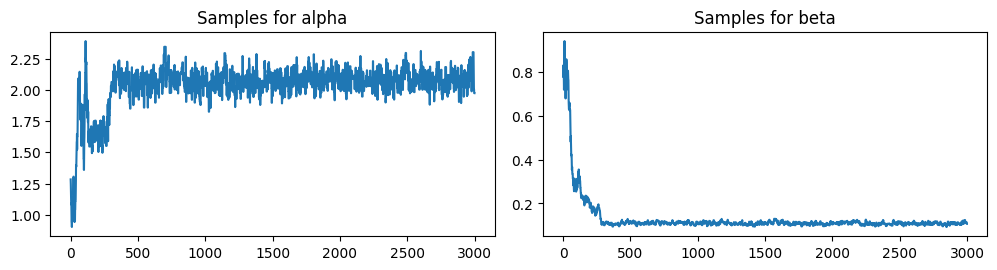

In [ ]:
# Plot the results
plt.figure(figsize=(10, 5))
for i, param in enumerate(['alpha', 'beta']):
    plt.subplot(2, 2, i + 1)
    plt.plot(jnp.exp(mh_samples[:,i]))
    plt.title(f'Samples for {param}')
    #plt.ylim((0,5))
plt.tight_layout()
plt.show()

In [ ]:
i=500
q1=np.quantile(mh_samples[i:,:], 0.05, axis=0)
q3=np.quantile(mh_samples[i:,:], 0.95, axis=0)
q2=np.quantile(mh_samples[i:,:], 0.5, axis=0)

In [ ]:
print(q1,q2,q3)

[ 0.66946291 -2.30429311] [ 0.72851617 -2.21595741] [ 0.7922108  -2.11281488]


In [ ]:
jnp.array([q1])

Array([[ 0.66946291, -2.30429311]], dtype=float64)

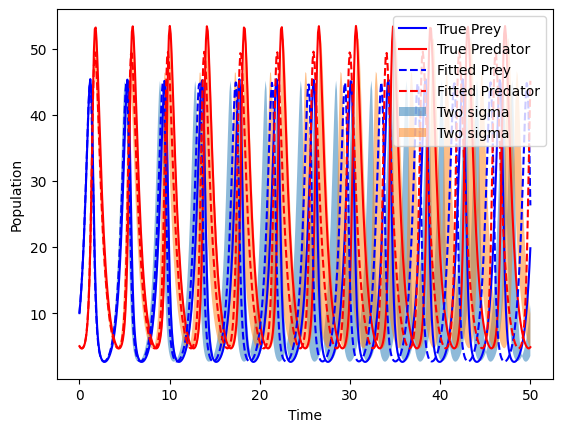

In [ ]:
fitted_model = integrate_model(np.exp(jnp.array(q2)), t, initial_conditions)
fitted_model1 = integrate_model(np.exp(jnp.array(q1)), t, initial_conditions)
fitted_model3 = integrate_model(np.exp(jnp.array(q3)), t, initial_conditions)


plt.figure()
plt.plot(t, data[:, 0], 'b-', label='True Prey')
plt.plot(t, data[:, 1], 'r-', label='True Predator')
plt.plot(t, fitted_model[:, 0], 'b--', label='Fitted Prey')
plt.plot(t, fitted_model[:, 1], 'r--', label='Fitted Predator')
plt.fill_between(
    t,
    fitted_model1[:, 0],
    fitted_model3[:, 0],
    alpha=0.5,
    label="Two sigma",
)
plt.fill_between(
    t,
    fitted_model1[:, 1],
    fitted_model3[:, 1],
    alpha=0.5,
    label="Two sigma",
)
plt.legend()
plt.xlabel('Time')
plt.ylabel('Population')
plt.show()

In [ ]:
def gpmh_eval_posterior_2d_new(posterior,x_prop,x_now,m_now,v_now,key,obs_stddev, D):
  x_eval = jnp.vstack([x_now,x_prop])

  #x_eval = x_eval
  #D = gpx.Dataset(x_current, y_current)

  #posterior = fit_gp(x_current, y_current, key, do_optimize=False, obs_stddev=obs_stddev)

  latent_dist = posterior.predict(jnp.array([x_eval[1]]), train_data=D)

  predictive_dist = posterior.likelihood(latent_dist)

  m = predictive_dist.mean().reshape(-1,1)
  v = predictive_dist.stddev().reshape(-1,1)
  #C = two_point_covariance(x_current, x_eval[0].reshape(-1,1), x_eval[1].reshape(-1,1), posterior)
  #print(m,x_eval,v)
  return m,v

def get_it_2d(posterior,x_current,x_prop,x_now,m_now,v_now,key,obs_stddev, D,m,v):
  x_eval = jnp.vstack([x_now,x_prop])

  #x_eval = x_eval.reshape(-1,1)
  C = two_point_covariance(x_current, jnp.array([x_eval[0]]), jnp.array([x_eval[1]]), posterior)
  #C1 = two_point_covariance(x_current, jnp.array([x_eval[0]]), jnp.array([x_eval[0]]), posterior)
  #C2 = two_point_covariance(x_current, jnp.array([x_eval[1]]), jnp.array([x_eval[1]]), posterior)
  #print(C,C1,C2,v_now**2-posterior.likelihood.obs_stddev**2,v**2-posterior.likelihood.obs_stddev**2)
  #print(m,x_eval)
  return m-m_now,v**2 + v_now**2 - 2*C-2*posterior.likelihood.obs_stddev**2

In [ ]:
D = gpx.Dataset(params_current, y_current)
#print(D)
posterior = fit_gp(params_current, y_current, key, do_optimize=True, obs_stddev=obs_stddev)
latent_dist = posterior.predict(jnp.array([mh_samples[0]]), train_data=D)
predictive_dist = posterior.likelihood(latent_dist)
m_now = predictive_dist.mean()
v_now = predictive_dist.stddev()
for i in range(1,N):
  # centred around prev step with var 1
  if proposal == 'uniform':
    params_prop = (np.random.uniform(0,1,2) - 0.5)*0.25 + mh_samples[i-1,:]
  else:
    params_prop=(np.random.normal(0,1,2)*0.25 + mh_samples[i-1])
  u = np.random.uniform()
  params_now=mh_samples[i-1]
  # find mean and variance of log likelihood ratio at proposal and prev point
  m_prop,v_prop = gpmh_eval_posterior_2d_new(posterior,x_prop,x_now,m_now,v_now,key,obs_stddev,D)
  m,v=get_it_2d(posterior,params_current,x_prop,x_now,m_now,v_now,key,obs_stddev,D,m_prop,v_prop)

  print('step',i,log_epsilon_gamma(m,v,u),expected1(m,v),jnp.log(epsilon),'Current',params_now,'proposed',params_prop)

  while expected1(m,v) > jnp.log(epsilon):# and np.size(test_points) >5:
  #while (expected1(m,v) > jnp.log(epsilon) or log_epsilon_gamma(m,v,u)>jnp.log(0.1)) and np.size(params_current) < 400:

    obs_stddev = 1e-3
    num_samples= 10

    #x_grid = jnp.arange(-5.0, 5.0, 0.01).reshape(-1, 1)
    params_grid = jnp.vstack([params_now,params_prop])#.reshape(-1,1)

    # how many do you need to set up
    x_range = jnp.arange(start = -3., stop = 3., step = 0.2 )
    y_range = jnp.arange(start = -3., stop = 3., step = 0.2 )

    x_gridvalues, y_gridvalues = jnp.meshgrid(x_range, y_range)
    test_points = jnp.vstack([x_gridvalues.flatten(), y_gridvalues.flatten()]).T
    '''
    max=round(jnp.max(x_grid),1)
    min=round(jnp.min(x_grid),1)

    #get lengthscale
    ls = posterior.prior.kernel.lengthscale
    print('lengthsxale:',ls)
    test_points = jnp.arange(min-round(5*ls,1), round(ls*5,1), 0.1)
    '''
    test_points=remove_close_rows(test_points,params_current)
    test_points= jnp.round(test_points,1)
    ## this remove points done needs work
    #test_points= jnp.array([testpt for testpt in test_points if testpt not in x_current])
    #test_points= jnp.round(test_points,1)
    #print(np.shape(test_points))
    test_point_utilities = loss_2023papernew(posterior,params_current, y_current, test_points,params_grid, key, obs_stddev)

    j = jnp.argmax(jnp.array(test_point_utilities))
    params_new = test_points[j]
    #y_new = l(x_new)
    params_current = jnp.vstack([params_current, params_new])
    y_current = log_likelihood_lv(params_current).reshape(-1,1)
    D = gpx.Dataset(params_current, y_current)

    posterior = fit_gp(params_current, y_current, key, do_optimize=True, obs_stddev=obs_stddev)
    m_prop,v_prop = gpmh_eval_posterior_2d_new(posterior,x_prop,x_now,m_now,v_now,key,obs_stddev,D)
    m,v=get_it_2d(posterior,params_current,x_prop,x_now,m_now,v_now,key,obs_stddev,D,m_prop,v_prop)
    print('chosen new point',params_new,'size',np.shape(params_current),jnp.exp(expected1(m,v)))
  print('m',m,'v',v,u)
  if m >= jnp.log(u):
    mh_samples[i] = params_prop
  else:
    mh_samples[i] = mh_samples[i-1]


  0%|          | 0/1000 [00:00<?, ?it/s]

step 1 [[-17.15498623]] -1.3275304271269133 -1.3862943611198906 Current [0. 0.] proposed [-0.11594337 -0.05713643]


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [0.2 0.2] size (68, 2) 0.15440890801663212
m [-6.7742674] v [[4.33337519e-05]] 0.6316384141091727
step 2 [[-645.6210039]] -1.2435981158050895 -1.3862943611198906 Current [0. 0.] proposed [-0.10640078 -0.03640495]


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-0.4  0. ] size (69, 2) 1.3586383475942966e-05
m [-6.78771413] v [[2.18085369e-05]] 0.681068358916635
step 3 [[-3230.31995515]] -12.386199369702137 -1.3862943611198906 Current [0. 0.] proposed [-0.11352913 -0.01391993]
m [-8.67467542] v [[1.52598172e-05]] 0.7063699171856646
step 4 [[-13.67514249]] -27.269973199605037 -1.3862943611198906 Current [0. 0.] proposed [-0.06718975 -0.06868105]
m [-2.0929621] v [[3.19332871e-05]] 0.9622048842898874
step 5 [[-5857.89332428]] -37.954349184842 -1.3862943611198906 Current [0. 0.] proposed [-0.02492141 -0.08450229]
m [0.89876896] v [[4.73305669e-05]] 0.4780126724546542
step 6 [[-8843.8147563]] -44.81726763564793 -1.3862943611198906 Current [-0.02492141 -0.08450229] proposed [-0.06592126 -0.14964138]
m [-0.81852422] v [[2.65849264e-05]] 0.5017144414852772
step 7 [[-12756.25672374]] -1.1501571468502507 -1.3862943611198906 Current [-0.02492141 -0.08450229] proposed [-0.13313994  0.00302514]


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [0.4 0.4] size (70, 2) 0.0007712339524128244
m [-19.13561748] v [[5.3099626e-05]] 0.23370431451694262
step 8 [[-21.53009288]] -4.0204651169602945 -1.3862943611198906 Current [-0.02492141 -0.08450229] proposed [-0.10927486 -0.20841868]
m [-2.10060467] v [[0.00014924]] 0.904369991154633
step 9 [[-1816.65873052]] -68.50844473645301 -1.3862943611198906 Current [-0.02492141 -0.08450229] proposed [-0.06183059 -0.07672972]
m [-3.01492037] v [[1.26361451e-05]] 0.7987637953330419
step 10 [[-106414.48357245]] -20.053043156212375 -1.3862943611198906 Current [-0.02492141 -0.08450229] proposed [-0.07679908 -0.06436632]
m [-5.17352965] v [[2.15026533e-05]] 0.11496028739773223
step 11 [[-9566.24934174]] -5.304401065376108 -1.3862943611198906 Current [-0.02492141 -0.08450229] proposed [-0.10194899 -0.03271762]
m [-10.64614046] v [[4.04172728e-05]] 0.3879887620770135
step 12 [[-10238.09187641]] -6.50560380499739 -1.3862943611198906 Current [-0.02492141 -0.08450229] proposed [0.00098521

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [0. 0.] size (71, 2) 6.62769524931122e-40
m [5.91707851] v [[5.00299053e-05]] 0.8060222990454329
step 17 [[-5596.14508965]] -1.892002745688012 -1.3862943611198906 Current [-0.11150263 -0.27971677] proposed [-0.19624012 -0.19890122]
m [-6.68187661] v [[0.00037542]] 0.11323541107233692
step 18 [[-1924.69296002]] -168.0846478789797 -1.3862943611198906 Current [-0.11150263 -0.27971677] proposed [-0.21492742 -0.38613676]
m [14.02079661] v [[0.00015616]] 0.5493076370286777
step 19 [[-43.94451816]] -3.0025762419725184 -1.3862943611198906 Current [-0.21492742 -0.38613676] proposed [-0.10987315 -0.35336767]
m [-6.19368032] v [[0.00017568]] 0.8172246362435679
step 20 [[-18740.06306833]] -53.61316140778437 -1.3862943611198906 Current [-0.21492742 -0.38613676] proposed [-0.25444336 -0.39981738]
m [1.47768032] v [[3.59059906e-05]] 0.3163128629686536
step 21 [[-22715.87911856]] -61.21132532317508 -1.3862943611198906 Current [-0.25444336 -0.39981738] proposed [-0.31554508 -0.49942429

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-0.4 -0.4] size (72, 2) 0.4326563628193557


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-0.2 -0.8] size (73, 2) 2.5494518988806903e-16
m [-26.80080683] v [[9.10873313e-06]] 0.7649823383346711
step 24 [[-667.28280001]] -701.1478723566947 -1.3862943611198906 Current [-0.31554508 -0.49942429] proposed [-0.25420775 -0.53453281]
m [28.00452657] v [[3.02808837e-05]] 0.9548106296183125
step 25 [[-16765.20933049]] -1.0668236664184108 -1.3862943611198906 Current [-0.25420775 -0.53453281] proposed [-0.29762746 -0.4617585 ]


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-0.2 -0.6] size (74, 2) 3.228753958820053e-10
m [-21.84547759] v [[1.07193755e-05]] 0.4495821173222396
step 26 [[-7821.84853021]] -15.238171215207913 -1.3862943611198906 Current [-0.25420775 -0.53453281] proposed [-0.28305592 -0.45743307]
m [-20.00515706] v [[1.77068432e-05]] 0.5431902461914159
step 27 [[-140287.46357056]] -2.2359264948630186 -1.3862943611198906 Current [-0.25420775 -0.53453281] proposed [-0.34586546 -0.53814476]
m [-12.87769872] v [[1.94369208e-05]] 0.09144750564861748
step 28 [[-150828.85473858]] -6.305958958548257 -1.3862943611198906 Current [-0.25420775 -0.53453281] proposed [-0.26792602 -0.47250718]
m [-14.56918861] v [[1.93441871e-05]] 0.08377155875230335
step 29 [[-21045.51953428]] -78.65119716392785 -1.3862943611198906 Current [-0.25420775 -0.53453281] proposed [-0.13396056 -0.52011774]
m [7.38253062] v [[0.00011035]] 0.1252642249882978
step 30 [[-4226.20592061]] -91.96169745363663 -1.3862943611198906 Current [-0.13396056 -0.52011774] proposed

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-0.4 -0.8] size (75, 2) 2.7324147818400183e-24
m [-4.68187259] v [[1.20392656e-05]] 0.16579087498213885
step 33 [[-184.52852568]] -42.75024972663752 -1.3862943611198906 Current [-0.27437747 -0.70328292] proposed [-0.15557343 -0.80158222]
m [-0.86662699] v [[2.75648466e-05]] 0.9009108490041862
step 34 [[-218715.21808937]] -251.92346983430298 -1.3862943611198906 Current [-0.27437747 -0.70328292] proposed [-0.26532398 -0.75227983]
m [2.22393478] v [[6.54956971e-06]] 0.18509143969273922
step 35 [[-2369.79963448]] -92.82221429335418 -1.3862943611198906 Current [-0.26532398 -0.75227983] proposed [-0.29394656 -0.67137034]
m [-6.267833] v [[6.82616269e-06]] 0.8219706943764751
step 36 [[-118464.292585]] -16.638121573290938 -1.3862943611198906 Current [-0.26532398 -0.75227983] proposed [-0.15614877 -0.69863692]
m [-5.0782719] v [[2.44497725e-05]] 0.0878721631833963
step 37 [[-3184.90614821]] -3.3289916053411264 -1.3862943611198906 Current [-0.26532398 -0.75227983] proposed [-0.

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.  -1.2] size (76, 2) 5.514963715391048e-30
m [4.8927191] v [[6.37837502e-05]] 0.7649384099973829
step 59 [[-99.58382311]] -2.721264104934275 -1.3862943611198906 Current [-0.31899275 -0.86496532] proposed [-0.43181329 -0.95683037]
m [-27.0735487] v [[0.00131611]] 0.6191461932597727
step 60 [[-55019.22418671]] -18.607988317050417 -1.3862943611198906 Current [-0.31899275 -0.86496532] proposed [-0.21403123 -0.91788031]
m [-0.3810865] v [[7.2468427e-05]] 0.059192866310349146
step 61 [[-0.79937111]] -1.5142967384210155 -1.3862943611198906 Current [-0.21403123 -0.91788031] proposed [-0.14558647 -0.84162324]
m [-7.1385412] v [[4.20410729e-05]] 0.9555535139022855
step 62 [[-172.58555451]] -59.42715746809669 -1.3862943611198906 Current [-0.21403123 -0.91788031] proposed [-0.10399042 -1.0068116 ]
m [8.36533556] v [[0.00052869]] 0.7944776539273204
step 63 [[-196.73368339]] -69.44406531854875 -1.3862943611198906 Current [-0.10399042 -1.0068116 ] proposed [-0.22518986 -1.1091128

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-0.2 -1.2] size (77, 2) 0.3025979453264733


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-0.4 -1. ] size (78, 2) 1.1527871185496671e-08
m [-2.41299928] v [[4.11057918e-05]] 0.6106629846475846
step 66 [[-300.61758834]] -1.5839434924197955 -1.3862943611198906 Current [-0.27242566 -1.20767754] proposed [-0.1922632  -1.26249525]
m [-17.50794506] v [[0.0003781]] 0.4431046669692613
step 67 [[-2095.70315243]] -63.25342315890581 -1.3862943611198906 Current [-0.27242566 -1.20767754] proposed [-0.31880203 -1.22982268]
m [5.96356814] v [[0.00010588]] 0.5466149492401653
step 68 [[-31.26677125]] -2.47070446861154 -1.3862943611198906 Current [-0.31880203 -1.22982268] proposed [-0.29553348 -1.11929466]
m [-9.47921028] v [[0.00022197]] 0.7762039809840175
step 69 [[-210.57717736]] -2.2367861692753603 -1.3862943611198906 Current [-0.31880203 -1.22982268] proposed [-0.28838191 -1.19496991]
m [-4.33550332] v [[8.45227451e-05]] 0.7971116195098904
step 70 [[-3509.57699511]] -11.581481967111806 -1.3862943611198906 Current [-0.31880203 -1.22982268] proposed [-0.4213934  -1.34301

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-0.6 -1.2] size (79, 2) 0.0032773854584122
m [0.28000845] v [[0.00044241]] 0.8983715280055196
step 74 [[-149.30599085]] -1.7392867981813795 -1.3862943611198906 Current [-0.47003915 -1.24041024] proposed [-0.57151459 -1.16652892]
m [-21.66958518] v [[0.00050998]] 0.9011677794743544
step 75 [[-638.73452732]] -1.234813787874461 -1.3862943611198906 Current [-0.47003915 -1.24041024] proposed [-0.53240969 -1.24724655]


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-0.6 -1.4] size (80, 2) 0.0004507398930046878
m [-4.07717446] v [[4.80880279e-05]] 0.6065875272721737
step 76 [[-46.02912619]] -2.3505155063198413 -1.3862943611198906 Current [-0.47003915 -1.24041024] proposed [-0.42096305 -1.14728862]
m [-6.44679006] v [[9.96634106e-05]] 0.8548727590588343
step 77 [[-11775.64079191]] -3.8823568557511954 -1.3862943611198906 Current [-0.47003915 -1.24041024] proposed [-0.48299407 -1.19743816]
m [-5.14101363] v [[5.10002436e-05]] 0.32226085488802314
step 78 [[-1263.4863552]] -0.9637890459985317 -1.3862943611198906 Current [-0.47003915 -1.24041024] proposed [-0.40038215 -1.15166683]


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-0.4 -1.6] size (81, 2) 5.128898640510718e-09
m [-3.09636184] v [[3.37995612e-05]] 0.5701457706639969
step 79 [[-10811.87930961]] -55.67270166904064 -1.3862943611198906 Current [-0.47003915 -1.24041024] proposed [-0.43931256 -1.29088304]
m [2.7983816] v [[4.75233191e-05]] 0.3700363931905102
step 80 [[-963.18281847]] -11.659086904333417 -1.3862943611198906 Current [-0.43931256 -1.29088304] proposed [-0.49183665 -1.27065016]
m [-2.79021973] v [[5.2374377e-05]] 0.7138713778272803
step 81 [[-44434.5732495]] -37.21412495005169 -1.3862943611198906 Current [-0.43931256 -1.29088304] proposed [-0.4431188  -1.23829539]
m [-1.42354791] v [[2.801916e-05]] 0.20486511565713794
step 82 [[-19.56502414]] -1.3351207882977882 -1.3862943611198906 Current [-0.4431188  -1.23829539] proposed [-0.46334391 -1.12698381]


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-0.4 -1.2] size (82, 2) 0.33995063278873877


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-0.6 -1.6] size (83, 2) 8.308939220355127e-08
m [-6.32063671] v [[1.97075914e-05]] 0.9488360421095021
step 83 [[-37002.77271482]] -18.631437391924194 -1.3862943611198906 Current [-0.4431188  -1.23829539] proposed [-0.51492055 -1.21242182]
m [-2.60916295] v [[3.85853604e-05]] 0.1816106958960093
step 84 [[-500.41004621]] -17.385100768961845 -1.3862943611198906 Current [-0.4431188  -1.23829539] proposed [-0.45765284 -1.11857002]
m [-6.71429736] v [[1.78390629e-05]] 0.8509586523206574
step 85 [[-1512.75865536]] -60.94153949132754 -1.3862943611198906 Current [-0.4431188  -1.23829539] proposed [-0.55814017 -1.34509284]
m [0.08890997] v [[2.32052683e-05]] 0.767890726912143
step 86 [[-2040.9858623]] -53.346405942378496 -1.3862943611198906 Current [-0.55814017 -1.34509284] proposed [-0.4383338  -1.23304485]
m [-0.22394417] v [[2.51140529e-05]] 0.725493363225155
step 87 [[-2153.22272458]] -1.36416401331645 -1.3862943611198906 Current [-0.4383338  -1.23304485] proposed [-0.51440

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-0.8 -1.2] size (84, 2) 0.00785134231632913
m [-8.21833645] v [[2.32659356e-05]] 0.619173903918186
step 88 [[-58931.12564612]] -163.2953674125252 -1.3862943611198906 Current [-0.4383338  -1.23304485] proposed [-0.42338565 -1.17551477]
m [-2.34173569] v [[6.44676035e-06]] 0.415788774414518
step 89 [[-48820.45785399]] -105.48219096765496 -1.3862943611198906 Current [-0.4383338  -1.23304485] proposed [-0.52263588 -1.3142487 ]
m [0.16225628] v [[1.32082853e-05]] 0.32143215529585056
step 90 [[-118683.84315207]] -66.37389638311782 -1.3862943611198906 Current [-0.52263588 -1.3142487 ] proposed [-0.41214427 -1.27041498]
m [2.31044805] v [[3.30883318e-05]] 0.06147389409667037
step 91 [[-85728.23333298]] -121.08319925003818 -1.3862943611198906 Current [-0.41214427 -1.27041498] proposed [-0.46824052 -1.30301862]
m [-0.62295209] v [[1.0344312e-05]] 0.2634965324544757
step 92 [[-29595.13593474]] -113.90614797103974 -1.3862943611198906 Current [-0.46824052 -1.30301862] proposed [-0

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-0.8 -1.6] size (85, 2) 0.059273298133635945
m [-7.09825244] v [[3.50889277e-05]] 0.03151514490792262
step 95 [[-3698.72957441]] -20.38792177579294 -1.3862943611198906 Current [-0.52214714 -1.46818833] proposed [-0.54634014 -1.38695577]
m [-4.12286716] v [[2.59663136e-05]] 0.6319371995725231
step 96 [[-16850.84543472]] -13.187101195663873 -1.3862943611198906 Current [-0.52214714 -1.46818833] proposed [-0.63531872 -1.55426663]
m [-2.84136323] v [[4.71980429e-05]] 0.2778977084141311
step 97 [[-31101.59131219]] -91.54418653682335 -1.3862943611198906 Current [-0.52214714 -1.46818833] proposed [-0.5882772  -1.46132878]
m [-4.20322189] v [[8.61828902e-06]] 0.4749993498126408
step 98 [[-116901.42161691]] -133.59860246679554 -1.3862943611198906 Current [-0.52214714 -1.46818833] proposed [-0.4880842  -1.44894814]
m [0.91864944] v [[1.13885323e-05]] 0.19620021258580878
step 99 [[-26489.86388666]] -26.11600172536691 -1.3862943611198906 Current [-0.4880842  -1.44894814] proposed 

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-0.2 -1.4] size (86, 2) 9.815011360047291e-21
m [3.08568995] v [[6.89183646e-05]] 0.09405126614126702
step 108 [[-1394.8601082]] -111.01597663464376 -1.3862943611198906 Current [-0.30617469 -1.5274538 ] proposed [-0.30985775 -1.56586174]
m [1.0786723] v [[1.42710528e-05]] 0.8227478540827644
step 109 [[-6913.48979129]] -3.729705769343833 -1.3862943611198906 Current [-0.30985775 -1.56586174] proposed [-0.29953547 -1.45388831]
m [-3.70485297] v [[8.14863008e-05]] 0.33471604352733164
step 110 [[-96433.58648252]] -121.71149733628639 -1.3862943611198906 Current [-0.30985775 -1.56586174] proposed [-0.32403235 -1.56253792]
m [-1.06455974] v [[9.74583601e-06]] 0.253022327758465
step 111 [[-276.44129117]] -8.697693437374596 -1.3862943611198906 Current [-0.32403235 -1.56253792] proposed [-0.28299509 -1.4399592 ]
m [-2.94675306] v [[6.16222155e-05]] 0.8135498821492076
step 112 [[-459.35249124]] -2.7155498417528583 -1.3862943611198906 Current [-0.32403235 -1.56253792] proposed [-0

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.  -1.6] size (87, 2) 0.27133603699141967


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.2 -1.4] size (88, 2) 9.945600864521077e-10
m [-4.17002926] v [[2.54441774e-05]] 0.702980655614707
step 120 [[-3227.82664915]] -145.26499417440903 -1.3862943611198906 Current [-0.11264742 -1.6270894 ] proposed [-0.0942454  -1.68207289]
m [14.2958499] v [[0.00041171]] 0.2621386400665525
step 121 [[-262.33403118]] -2.8281548189422914 -1.3862943611198906 Current [-0.0942454  -1.68207289] proposed [-0.08033801 -1.55856167]
m [-28.05939436] v [[0.00123698]] 0.16758867190537208
step 122 [[-2370.64879298]] -3.544455498044843 -1.3862943611198906 Current [-0.0942454  -1.68207289] proposed [-0.16002708 -1.67802619]
m [-6.86335514] v [[0.00014179]] 0.4062583493704661
step 123 [[-2032.71474585]] -1193.1131812141725 -1.3862943611198906 Current [-0.0942454  -1.68207289] proposed [-0.05480991 -1.80423708]
m [48.2837321] v [[0.01207432]] 0.1841668794299347
step 124 [[-64.0815939]] -4.927348595561781 -1.3862943611198906 Current [-0.05480991 -1.80423708] proposed [-0.12401215 -1.7650

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.4 -2.2] size (89, 2) 6.6447541459567195e-77
m [-32.652997] v [[0.04495385]] 0.9015380947942634
step 137 [[-13.2042223]] -4.944759321551211 -1.3862943611198906 Current [ 0.06237565 -2.21304834] proposed [ 0.08292278 -2.10992558]
m [-11.96500264] v [[0.0991512]] 0.09924331904012618
step 138 [[-389.02149455]] -191.87111074135439 -1.3862943611198906 Current [ 0.06237565 -2.21304834] proposed [ 0.15869926 -2.32806947]
m [-27.85510202] v [[0.12523764]] 0.9603858579556954
step 139 [[-660.31708438]] -477.7159488259032 -1.3862943611198906 Current [ 0.06237565 -2.21304834] proposed [ 0.18186785 -2.12764054]
m [-38.33988376] v [[0.15657661]] 0.4315713884827874
step 140 [[-94.25915788]] -13.162209577040704 -1.3862943611198906 Current [ 0.06237565 -2.21304834] proposed [ 0.10856866 -2.13561602]
m [-15.19574438] v [[0.08023354]] 0.6135238429050492
step 141 [[-698.47733268]] -338.85863274126075 -1.3862943611198906 Current [ 0.06237565 -2.21304834] proposed [ 0.18635038 -2.2156803

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.2 -2.4] size (90, 2) 0.4303232288212999


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-0.2 -2. ] size (91, 2) 0.6491931502568136


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.4 -2.6] size (92, 2) 0.02830562600856741
m [-0.07605585] v [[0.00066918]] 0.020935383183686374
step 146 [[-417.08755637]] -246.67684179755713 -1.3862943611198906 Current [ 0.05602223 -2.23383967] proposed [-0.01884334 -2.32821837]
m [-33.65727292] v [[0.06638354]] 0.28122805799883044
step 147 [[-702.50336433]] -558.2106709976092 -1.3862943611198906 Current [ 0.05602223 -2.23383967] proposed [-0.04213664 -2.34303811]
m [-42.34554707] v [[0.10920365]] 0.19265957248449617
step 148 [[-72.02586638]] -78.10664133060867 -1.3862943611198906 Current [ 0.05602223 -2.23383967] proposed [ 0.05560066 -2.17889122]
m [11.3318962] v [[0.00332731]] 0.9780564256453242
step 149 [[-156.78222476]] -7.9017565306718724 -1.3862943611198906 Current [ 0.05560066 -2.17889122] proposed [-0.00312874 -2.11707692]
m [1.77953401] v [[0.00103436]] 0.6032886103421844
step 150 [[-1939.73991636]] -45.01041860526524 -1.3862943611198906 Current [-0.00312874 -2.11707692] proposed [-0.02542179 -2.0174433

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.  -2.2] size (93, 2) 9.167458819910131e-17
m [6.23905929] v [[0.00066209]] 0.853837064473258
step 153 [[-614.45945184]] -0.7303913683662376 -1.3862943611198906 Current [-0.04406656 -1.91911893] proposed [-0.03289312 -1.97344985]


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.  -2.4] size (94, 2) 0.14637213076773659
m [-2.38263308] v [[0.00022301]] 0.43430493096834866
step 154 [[-24.56146716]] -0.1682632003978698 -1.3862943611198906 Current [-0.04406656 -1.91911893] proposed [ 0.08066502 -2.019904  ]


## 4d

In [16]:
def is_point_in_box(point, min_corner, max_corner):
    """
    Check if a point is inside an axis-aligned box.

    Parameters:
    point (array-like): Coordinates of the point (e.g., [x, y, z]).
    min_corner (array-like): Coordinates of the minimum corner of the box.
    max_corner (array-like): Coordinates of the maximum corner of the box.

    Returns:
    bool: True if the point is inside the box, False otherwise.
    """
    # Convert inputs to numpy arrays for element-wise operations

    min_corner = jnp.array(min_corner)
    max_corner = jnp.array(max_corner)

    # Check if the point is within the bounds
    return jnp.all(point >= min_corner) and jnp.all(point <= max_corner)

# Example usage with arrays:
point = jnp.array([7,3,4])
min_corner = jnp.array([1, 2, 3])
max_corner = jnp.array([5, 6, 7])

if is_point_in_box(point, min_corner, max_corner):
    print("The point is inside the box.")
else:
    print("The point is outside the box.")

The point is outside the box.


In [17]:
def gpmh_eval_posterior_wp(posterior,x_current,x_prop,x_now,key,obs_stddev, D ,min,max):
  x_eval = jnp.vstack((x_now,x_prop))
  latent_dist = posterior.predict(x_eval, train_data=D)
  predictive_dist = posterior.likelihood(latent_dist)
  v = predictive_dist.stddev().reshape(-1,1)
  C = two_point_covariance(x_current, jnp.array([x_eval[0]]), jnp.array([x_eval[1]]), posterior)
  #x_eval = x_eval.reshape(-1,1)
  #D = gpx.Dataset(x_current, y_current)
  if not is_point_in_box(x_prop,min,max):
    mean= -(1e+5)

  else:
    m = predictive_dist.mean().reshape(-1,1)
    mean= m[1]-m[0]


  return mean,v[0]**2 + v[1]**2 - 2*C-2*posterior.likelihood.obs_stddev**2

In [18]:
from jax import vmap
from jax.experimental.ode import odeint

In [19]:
def lotka_volterra(X, t, alpha, beta, delta, gamma):
    x, y = X
    dxdt = alpha * x - beta * x * y
    dydt = delta * x * y - gamma * y
    return [dxdt, dydt]

# Vectorized integration function
def integrate_model(params, t, initial_conditions):
    alpha, beta, delta, gamma = params

    # Define the ODE function for a single set of parameters
    def odefunc(X, t):
        return lotka_volterra(X, t, alpha, beta, delta, gamma)

    # Integrate the ODE
    return odeint(odefunc, initial_conditions, t)

# Vectorized log-likelihood function
@jit
def log_likelihood_lv(log_params):#, t, data, initial_conditions):
    # Ensure params are in the correct shape (N, 4) where N is the number of parameter sets

    params=jnp.exp(log_params)
    def integrate_single(params):
        return integrate_model(params, t, initial_conditions)
    # Vectorize integration over parameter sets
    models = vmap(integrate_single)(params)
    # Compute the error and log-likelihood for each parameter set
    errors = data - models
    sigma = 5000
    log_likelihoods = -jnp.sum(errors**2, axis=(1, 2)) / (2*sigma) + 10.
    return log_likelihoods

# Example data
true_params = jnp.array([2.0, 0.1,0.1,1.5])
initial_conditions = jnp.array([10.0, 5.0])
t = jnp.linspace(0, 50, 500)
data = integrate_model(true_params, t, initial_conditions)

# Initial guess for parameters
initial_params = jnp.array([[1.0, 0.05,1.0,0.1], [2.0, 0.1,2.0,0.1],[1.1,1.1,1.1,1.1]])

# Compute log-likelihoods for each parameter set
ll_values = log_likelihood_lv(initial_params)#, t, data, initial_conditions)
print("Log-Likelihoods:", ll_values)

Log-Likelihoods: [-39.3908751  -40.88475172 -40.54467613]


In [20]:
N = 300
mh_samples=np.zeros((N,4))
mh_samples[0]=np.array([0.5,-1.0,-1.5,-0.5])
# define x current and y_current
np.random.seed(10)
#params_current =  jnp.array([[1.5, 1.5,1.5,1.5], [2.0, 0.1,2.0,0.1],[-1.5,-1.5,-1.5,-1.5],[-5.0,-2.5,-2.5,-5.0],[5.0,2.5,2.5,5.0]])
params_current = jnp.array(np.random.uniform([-2,-3,-3,-2],[2,1,1,2],(20,4)))
#params_current = jnp.array((np.random.uniform(0,1,(70,4)) - 0.5)*[0.1,0.01,0.01,0.1] + mh_samples[0,:])
params_current=round(params_current,1)
true_params = jnp.array([2.0, 0.1,0.1,1.5])
initial_conditions = jnp.array([10.0, 5.0])
t = jnp.linspace(0, 50, 500)
#data = generate_synthetic_data(true_params, initial_conditions, t)
y_current = jnp.array(log_likelihood_lv(params_current).reshape(-1,1))
# set up empty mh_samples

epsilon = 0.3
obs_stddev=1e-3
proposal='uniform'

In [21]:
params_current

Array([[ 1.1, -2.9, -0.5,  1. ],
       [-0. , -2.1, -2.2,  1. ],
       [-1.3, -2.6, -0.3,  1.8],
       [-2. , -1. ,  0.3,  0.5],
       [ 0.9, -1.8,  0.7,  0.9],
       [ 0.2, -2.4, -1.5,  0.7],
       [-0.2, -1.3, -0.5,  0.1],
       [ 0.6, -0.6,  0.2,  0.1],
       [ 1.6, -1.7, -2.6, -0.8],
       [-1.5,  0.3, -2.8,  0.5],
       [ 0.2,  0.3, -2.2,  1.4],
       [-0.6,  0. , -1.8,  1.5],
       [-0.7, -2.3, -1.4, -1.6],
       [ 1.3, -2.4, -1.5,  1.8],
       [ 2. , -1.2,  0.3, -1. ],
       [ 0.4,  0.6, -0.9,  0.4],
       [-1.8, -1.6, -2.7, -0.8],
       [-0.7,  0.1, -2.8, -0.3],
       [-0.7, -0.5, -1.6, -1.8],
       [ 1.5,  0.1,  0.5, -0.3]], dtype=float64)

In [22]:
from sklearn.metrics.pairwise import pairwise_distances
def remove_close_rows(arr1, arr2, threshold=1e-6):
    # Compute the distance between each pair of rows
    distances = pairwise_distances(arr1,arr2)
    #print(distances)

    # Check if any distance is below the threshold for each row in arr1
    is_close = jnp.any(distances < threshold, axis=1)

    # Keep rows that are not close to any row in arr2
    result = arr1[~is_close]

    return result

In [64]:
np.random.seed(10)
N = 10000
mh_samples=np.zeros((N,4))
mh_samples[0] = np.array([0.,-1,-1,0.])
#mh_samples[0] = np.array([0.25,-2.5,-2.5,0.6])
#mh_samples[0]=np.array([0.6, -0.6,  0.2,  0.1])
#mh_samples[0] = np.array([0.6, -2.25,  -2.25,  0.3])#0.60, -2.20,  -2.20,  0.30
t_0 = 30
q_means=np.zeros((N,4))
q_means[0] = mh_samples[0]
q_cov = np.eye(4)*0.25#[0.1,0.025,0.025,0.1]#[0.1,0.025,0.025,0.1]#[0.1,0.01,0.01,0.1]

params_current=jnp.array(np.random.multivariate_normal(mh_samples[0],q_cov,20))
params_current=round(params_current,1)
y_current = jnp.array(log_likelihood_lv(params_current).reshape(-1,1))
epsilon = 0.2
obs_stddev=1e-3
proposal='normal'
D = gpx.Dataset(params_current, y=y_current)
#print(D)
posterior = fit_gp(params_current, y_current, key, do_optimize=True, obs_stddev=obs_stddev)
mini = jnp.array([-2,-3,-3,-2])
maxi=jnp.array([2,1,1,2])

'''# how many do you need to set up
x1_range = jnp.arange(start = -3., stop = 3., step = 1.0 )
x2_range = jnp.arange(start = -3., stop = 3., step = 1.0 )
x3_range = jnp.arange(start = -3., stop = 3., step = 1.0 )
x4_range = jnp.arange(start = -2., stop = 2., step = 1.0 )
x1_gridvalues, x2_gridvalues, x3_gridvalues,x4_gridvalues = jnp.meshgrid(x1_range, x2_range,x3_range,x4_range)
test_points = jnp.vstack([x1_gridvalues.flatten(), x2_gridvalues.flatten(), x3_gridvalues.flatten(), x4_gridvalues.flatten()]).T
'''
for i in range(1,N):
  # centred around prev step with var 1
  if i > t_0:
    q_cov=((i-2)/(i-1))*q_cov + ((2.4**2)/(4*(i-1)))*((i-1)*(np.outer(q_means[i-2],q_means[i-2]))-i*np.outer(q_means[i-1],q_means[i-1])+np.outer(mh_samples[i-1],mh_samples[i-1])+ 1e-9*np.eye(4))
  if proposal == 'uniform':
    params_prop = (np.random.uniform(0,1,4) - 0.5)*[0.1,0.1,0.1,0.1]*3.0 + mh_samples[i-1,:]
  else:
    params_prop=np.random.multivariate_normal(mh_samples[i-1],q_cov)
  u = np.random.uniform()


  params_now=mh_samples[i-1]
  # find mean and variance of log likelihood ratio at proposal and prev point
  m,v = gpmh_eval_posterior_wp(posterior,params_current,params_prop,params_now,key,obs_stddev,D,mini,maxi)

  print('step',i,'m',m,'v',v,log_epsilon_gamma(m,v,u),expected1(m,v),expected(m,v),jnp.log(epsilon),'Current',params_now,'proposed',params_prop,posterior.likelihood.obs_stddev**2)


  #generate test points if necessary
  if (expected(m,v) > epsilon):
    params_grid = jnp.vstack([params_now,params_prop])#.reshape(-1,1)
    #max=round(jnp.max(params_grid)+0.7,1)
    #min=round(jnp.min(params_grid)-0.7,1)
    max=round(jnp.minimum(jnp.max(params_grid)+0.7,maxi),1)
    min=round(jnp.maximum(jnp.min(params_grid)-0.7,mini),1)
    test_points = round(jnp.array(np.random.uniform(min,max,(1000,4))),1)
    test_points= remove_close_rows(test_points,params_current)
  npc=0
  while (expected(m,v) > epsilon) and np.size(test_points) >5:
  #while (log_epsilon_gamma(m,v,u) > jnp.log(epsilon)) and np.size(test_points) >5:
    test_points= remove_close_rows(test_points,params_current)

    #x_grid = jnp.arange(-5.0, 5.0, 0.01).reshape(-1, 1)
    #params_grid = jnp.vstack([params_now,params_prop])#.reshape(-1,1)
    #max=round(jnp.max(params_grid)+1.0,1)
    #min=round(jnp.min(params_grid)-1.0,1)

    #get lengthscale
    #ls = posterior.prior.kernel.lengthscale
    #print('lengthsxale:',ls)
    #test_points = jnp.arange(min-round(5*ls,1), round(ls*5,1), 0.1)
    #test_points = round(jnp.array(np.random.uniform(min,max,(100,4))),1)
    #test_points= remove_close_rows(test_points,params_current)
    #test_point_utilities = loss_2023paper(params_current, y_current, test_points,params_grid, key, obs_stddev)
    test_point_utilities = loss_2023papernew(posterior,params_current, y_current, test_points,params_grid, key, obs_stddev)

    j = jnp.argmax(jnp.array(test_point_utilities))
    params_new = test_points[j]

    y_new = log_likelihood_lv(jnp.array([params_new]))

    npc+=1
    while np.isnan(y_new):
      test_points=jnp.delete(test_points,j,axis=0)
      test_point_utilities = loss_2023papernew(posterior,params_current, y_current, test_points,params_grid, key, obs_stddev)
      j = jnp.argmax(jnp.array(test_point_utilities))
      params_new = test_points[j]
      y_new = log_likelihood_lv(jnp.array([params_new]))
      npc+=1
      if npc > 20:
        print('fail')
        break
    if npc > 20:
      print('fail')
      break
    params_current = jnp.vstack([params_current, params_new])
    y_current = log_likelihood_lv(params_current).reshape(-1,1)
    D = gpx.Dataset(params_current, y_current)

    posterior = fit_gp(params_current, y_current, key, do_optimize=True, obs_stddev=obs_stddev)
    m,v = gpmh_eval_posterior_wp(posterior,params_current,params_prop,params_now,key,obs_stddev, D,mini,maxi)
    print('chosen new point',params_new,'size',np.shape(params_current),jnp.exp(expected1(m,v)),expected(m,v),epsilon_gamma(m,v,u))
  print('m',m,'v',v,u)
  if m >= jnp.log(u):
    mh_samples[i] = params_prop
  else:
    mh_samples[i] = mh_samples[i-1]

  q_means[i] = q_means[i-1] + (mh_samples[i]-q_means[i-1])/(i+1)


  0%|          | 0/1000 [00:00<?, ?it/s]

step 1 m [7.28144206] v [[0.70537796]] [[-58.93257606]] -28.997895011338517 [[1.87052326e-19]] -1.6094379124341003 Current [ 0. -1. -1.  0.] proposed [ 0.9925423  -0.12759293 -1.92809274 -0.11138685] 1.013896356132483e-06
m [7.28144206] v [[0.70537796]] 0.06425106069482445
step 2 m [15.95885013] v [[2.73583328]] [[-137.45096934]] -130.69458365136757 [[3.59271233e-23]] -1.6094379124341003 Current [ 0.9925423  -0.12759293 -1.92809274 -0.11138685] proposed [ 1.20902205 -0.12983965 -2.86045343 -0.41524978] 1.013896356132483e-06
m [15.95885013] v [[2.73583328]] 0.5197969858753801
step 3 m [5.61291772] v [[1.76490834]] [[-19.51303557]] -17.26688491259722 [[2.67778771e-06]] -1.6094379124341003 Current [ 1.20902205 -0.12983965 -2.86045343 -0.41524978] proposed [ 1.76287617 -0.00756767 -2.89140945 -0.79219626] 1.013896356132483e-06
m [5.61291772] v [[1.76490834]] 0.7819491186191484
step 4 m -100000.0 v [[3.18698961]] [[-4.99996785e+09]] -4999832205.834919 [[0.]] -1.6094379124341003 Current [ 1.

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 1.3 -0.8 -2.6 -1.4] size (21, 4) 2.412485208606942e-50 [[6.10849645e-07]] [[9.68533257e-60]]
m [-16.34431684] v [[4.1565219]] 0.8398874811543805
step 61 m [2.98485217] v [[1.08667477]] [[-7.2937004]] -5.138535805112316 [[0.00049639]] -1.6094379124341003 Current [ 0.84901251  0.81499856 -2.6179561  -1.64914322] proposed [ 0.41117574  0.93231432 -2.62570471 -1.83853049] 1.013896356132483e-06
m [2.98485217] v [[1.08667477]] 0.7965232270552005
step 62 m [-16.59741609] v [[3.56835255]] [[-136.97609375]] -116.30148306605624 [[3.47001819e-07]] -1.6094379124341003 Current [ 0.41117574  0.93231432 -2.62570471 -1.83853049] proposed [ 0.81587728  0.08342436 -2.21219586 -1.37560236] 1.013896356132483e-06
m [-16.59741609] v [[3.56835255]] 0.5982883874255968
step 63 m -100000.0 v [[3.50603364]] [[-4.9999451e+09]] -4999840022.930632 [[0.]] -1.6094379124341003 Current [ 0.41117574  0.93231432 -2.62570471 -1.83853049] proposed [-0.42506783  1.06463786 -2.3065364  -2.08770121] 1.01389

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-0.5  1.  -2.3 -1.6] size (22, 4) 1.5604336827321543e-38 [[1.32640337e-24]] [[3.20693476e-41]]
m [12.95115485] v [[1.69160377]] 0.5609755069740989
step 111 m -100000.0 v [[2.34088851]] [[-4.99996066e+09]] -4999804214.373 [[0.]] -1.6094379124341003 Current [ 0.88235457  0.86925699 -2.57021395 -1.87955618] proposed [ 0.2905375   1.42571981 -2.54554086 -2.1081441 ] 1.013896356132483e-06
m -100000.0 v [[2.34088851]] 0.5477037863446881
step 112 m [-2.86152588] v [[2.92227343]] [[-1.89905392]] -0.9850504195060188 [[0.14529335]] -1.6094379124341003 Current [ 0.88235457  0.86925699 -2.57021395 -1.87955618] proposed [ 1.52485171 -0.14322769 -2.5597352  -1.51989514] 1.013896356132483e-06
m [-2.86152588] v [[2.92227343]] 0.04425410873451807
step 113 m -100000.0 v [[6.50431781]] [[-4.99997884e+09]] -4999882549.84231 [[0.]] -1.6094379124341003 Current [ 1.52485171 -0.14322769 -2.5597352  -1.51989514] proposed [ 2.79555563 -1.05277752 -2.78071789 -0.21399159] 1.013896356132483e-06


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 1.8  0.  -1.7 -1.5] size (23, 4) 7.126519143283025e-06 [[4.21296012e-05]] [[3.79746824e-07]]
m [4.61574928] v [[1.66369413]] 0.6535578356816858
step 135 m [5.35491235] v [[0.67882967]] [[-18.2621183]] -16.242705604631617 [[4.37311574e-12]] -1.6094379124341003 Current [ 1.29641114  0.97691935 -2.34398267 -1.49446138] proposed [ 1.72204842  0.99069525 -2.41007156 -1.57449511] 1.013896356132483e-06
m [5.35491235] v [[0.67882967]] 0.8276499100076001
step 136 m -100000.0 v [[0.60363449]] [[-4.99934507e+09]] -4999614438.554794 [[0.]] -1.6094379124341003 Current [ 1.72204842  0.99069525 -2.41007156 -1.57449511] proposed [ 2.05498849  0.84886589 -2.27517816 -1.69694958] 1.013896356132483e-06
m -100000.0 v [[0.60363449]] 0.006166107192511983
step 137 m -100000.0 v [[1.02520571]] [[-4.99997549e+09]] -4999704149.153804 [[0.]] -1.6094379124341003 Current [ 1.72204842  0.99069525 -2.41007156 -1.57449511] proposed [ 2.18724159  1.24288751 -2.41616304 -1.48501881] 1.013896356132483

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 1.6  0.2 -1.6 -0.4] size (24, 4) 1.436658963268868 [[0.10479007]] [[0.03050277]]
m [-2.57675334] v [[1.35960653]] 0.44040493152488047
step 173 m [-5.4423027] v [[0.24611891]] [[-0.92594264]] -0.5799820739419638 [[0.00186153]] -1.6094379124341003 Current [ 1.72204842  0.99069525 -2.41007156 -1.57449511] proposed [ 1.55426465  0.84782773 -2.31372132 -1.43437415] 1.013896356132483e-06
m [-5.4423027] v [[0.24611891]] 0.07658759740454801
step 174 m -100000.0 v [[1.89148999]] [[-4.99989368e+09]] -4999782193.188964 [[0.]] -1.6094379124341003 Current [ 1.72204842  0.99069525 -2.41007156 -1.57449511] proposed [ 2.19125075  1.41564474 -2.22382563 -1.97812771] 1.013896356132483e-06
m -100000.0 v [[1.89148999]] 0.23166756967338087
step 175 m [-3.93100108] v [[0.52640259]] [[-2.42741994]] -0.18203247467652073 [[0.01358018]] -1.6094379124341003 Current [ 1.72204842  0.99069525 -2.41007156 -1.57449511] proposed [ 1.92156315  0.69897384 -2.31927694 -1.38496523] 1.013896356132483e-06

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 1.9  0.1 -2.2 -1.9] size (25, 4) 1.696223391798937 [[0.05372502]] [[0.13107054]]
m [0.4117839] v [[0.28721082]] 0.6836779442840687
step 231 m [-1.82502937] v [[0.66237853]] [[-1.76262223]] 1.2105609088263558 [[0.12645301]] -1.6094379124341003 Current [ 1.75551845  0.98354855 -2.45397073 -1.25072611] proposed [ 1.77632271  0.65619356 -2.72537558 -1.57332802] 1.013896356132483e-06
m [-1.82502937] v [[0.66237853]] 0.10468694535980794
step 232 m -100000.0 v [[3.40485068]] [[-4.99999886e+09]] -4999837663.125382 [[0.]] -1.6094379124341003 Current [ 1.77632271  0.65619356 -2.72537558 -1.57332802] proposed [ 1.35656871  1.50065138 -2.50455288 -2.24967954] 1.013896356132483e-06
m -100000.0 v [[3.40485068]] 0.9790302420395895
step 233 m -100000.0 v [[3.85700263]] [[-4.99975269e+09]] -4999847475.601286 [[0.]] -1.6094379124341003 Current [ 1.77632271  0.65619356 -2.72537558 -1.57332802] proposed [ 2.86259304  1.01674494 -2.42234068 -1.77482077] 1.013896356132483e-06
m -100000.0 

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.7  0.1 -2.6 -1. ] size (26, 4) 1.9722797663749025 [[0.09128872]] [[0.09940837]]
m [0.5528779] v [[0.72343543]] 0.5365223893642874
step 252 m [-7.33346447] v [[0.8283374]] [[-22.72369373]] -10.50566032075544 [[0.00062993]] -1.6094379124341003 Current [ 1.83280701  0.90483082 -2.56664749 -1.27516493] proposed [ 1.18931817  0.76515108 -2.68184966 -1.20927411] 1.013896356132483e-06
m [-7.33346447] v [[0.8283374]] 0.3956836448038552
step 253 m [-11.64819396] v [[1.00600506]] [[-57.1655073]] -40.59891901504394 [[9.88208758e-06]] -1.6094379124341003 Current [ 1.83280701  0.90483082 -2.56664749 -1.27516493] proposed [ 1.22657754  0.49826001 -2.50798599 -1.09261182] 1.013896356132483e-06
m [-11.64819396] v [[1.00600506]] 0.2809543910300225
step 254 m -100000.0 v [[5.09599723]] [[-4.99999679e+09]] -4999867307.970102 [[0.]] -1.6094379124341003 Current [ 1.83280701  0.90483082 -2.56664749 -1.27516493] proposed [ 2.961716    0.17981831 -2.78454989 -0.47107472] 1.013896356132483

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.5  0.7 -2.8 -1. ] size (27, 4) 1.0709449025022657e-15 [[1.38747554e-05]] [[6.83589716e-21]]
m [-11.17377413] v [[0.85452938]] 0.17737530679141034
step 260 m -100000.0 v [[1.64979334]] [[-4.99999465e+09]] -4999766783.104418 [[0.]] -1.6094379124341003 Current [ 1.83280701  0.90483082 -2.56664749 -1.27516493] proposed [ 1.78417329  1.64659438 -2.6321919  -1.07727668] 1.013896356132483e-06
m -100000.0 v [[1.64979334]] 0.9333973014341377
step 261 m [4.74560029] v [[1.48120419]] [[-17.89860481]] -12.560160551288538 [[1.06459395e-05]] -1.6094379124341003 Current [ 1.83280701  0.90483082 -2.56664749 -1.27516493] proposed [ 1.9590116   0.56867878 -2.74133738 -0.73972015] 1.013896356132483e-06
m [4.74560029] v [[1.48120419]] 0.3891930222089224
step 262 m [1.66525859] v [[0.65717695]] [[-4.15769796]] -1.499918178172392 [[0.0046596]] -1.6094379124341003 Current [ 1.9590116   0.56867878 -2.74133738 -0.73972015] proposed [ 1.8723131   0.97275944 -2.93123808 -0.70128771] 1.013896

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 1.7  0.3 -2.6  0.1] size (28, 4) 0.18774032453349962 [[0.03055683]] [[0.01215791]]
m [1.8962511] v [[1.79543472]] 0.6207552011400684
step 359 m -100000.0 v [[2.15596293]] [[-4.99994957e+09]] -4999795989.99841 [[0.]] -1.6094379124341003 Current [ 0.67478647  0.09554571 -2.97369552  0.48949175] proposed [ 0.13665379 -0.31542521 -3.45191845  0.82820067] 1.013896356132483e-06
m -100000.0 v [[2.15596293]] 0.47681396657488473
step 360 m -100000.0 v [[3.07507562]] [[-4.99987524e+09]] -4999829179.581103 [[0.]] -1.6094379124341003 Current [ 0.67478647  0.09554571 -2.97369552  0.48949175] proposed [ 0.49204984 -0.56004094 -3.20713855  1.27298082] 1.013896356132483e-06
m -100000.0 v [[3.07507562]] 0.11214839647549024
step 361 m -100000.0 v [[2.92882753]] [[-4.99993707e+09]] -4999824966.388637 [[0.]] -1.6094379124341003 Current [ 0.67478647  0.09554571 -2.97369552  0.48949175] proposed [ 1.02386894  0.18312584 -3.43715481  1.33590599] 1.013896356132483e-06
m -100000.0 v [[2.9288

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 1.2  0.7 -1.6  1.8] size (29, 4) 1.7888287570883083e-83 [[6.48418187e-10]] [[7.03436991e-100]]
m [-21.70850256] v [[1.57439183]] 0.5163691730106141
step 404 m -100000.0 v [[1.576807]] [[-4.99997425e+09]] -4999761446.432275 [[0.]] -1.6094379124341003 Current [ 1.97901942 -0.27341033 -2.68098713  1.82488391] proposed [ 1.90510265 -0.37153415 -3.28272539  1.76501771] 1.013896356132483e-06
m -100000.0 v [[1.576807]] 0.7235981981869162
step 405 m -100000.0 v [[6.58659677]] [[-4.99998662e+09]] -4999883285.807799 [[0.]] -1.6094379124341003 Current [ 1.97901942 -0.27341033 -2.68098713  1.82488391] proposed [ 1.1991479   0.69727605 -3.07996698  0.2263357 ] 1.013896356132483e-06
m -100000.0 v [[6.58659677]] 0.7090687146892052
step 406 m [-6.26016119] v [[5.69569659]] [[-22.14484828]] -14.739988298660474 [[0.02336041]] -1.6094379124341003 Current [ 1.97901942 -0.27341033 -2.68098713  1.82488391] proposed [ 1.82859571  0.01299152 -2.45328132 -0.40604215] 1.013896356132483e-06
m 

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.9 -1.  -2.1  1.8] size (30, 4) 1.6295806084046043e-201 [[6.29674867e-16]] [[3.31942571e-230]]
m [-34.57541526] v [[0.48314244]] 0.21631139206617345
step 411 m [-22.15859655] v [[0.9582106]] [[-219.75205059]] -186.242576919581 [[2.58416154e-10]] -1.6094379124341003 Current [ 1.97901942 -0.27341033 -2.68098713  1.82488391] proposed [ 1.57448429 -0.46403198 -2.865886    1.8577594 ] 1.013896356132483e-06
m [-22.15859655] v [[0.9582106]] 0.25806824941166895
step 412 m -100000.0 v [[3.95753858]] [[-4.99998211e+09]] -4999849425.546917 [[0.]] -1.6094379124341003 Current [ 1.97901942 -0.27341033 -2.68098713  1.82488391] proposed [ 1.14628656 -0.45010121 -3.02168318  2.32280918] 1.013896356132483e-06
m -100000.0 v [[3.95753858]] 0.7004265128771759
step 413 m -100000.0 v [[1.84769993]] [[-4.99999991e+09]] -4999779627.198802 [[0.]] -1.6094379124341003 Current [ 1.97901942 -0.27341033 -2.68098713  1.82488391] proposed [ 1.54439943 -0.47186819 -2.72833506  2.30929041] 1.01389635

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-0.3 -0.4 -2.6 -0.7] size (31, 4) 1.1138720277992152e-45 [[1.98809403e-89]] [[1.12379836e-47]]
m [14.09317535] v [[0.50420036]] 0.7720479997092674
step 422 m [-1.54833382] v [[2.77959687]] [[-1.96054737]] 1.1908993384694941 [[0.29141405]] -1.6094379124341003 Current [ 0.7673983  -0.24454171 -2.13604191 -0.19212492] proposed [ 0.89632578 -0.08816576 -1.96591572 -1.93581711] 1.013896356132483e-06


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.8 -0.2 -2.3 -1.5] size (32, 4) 6.739565866065627e-10 [[4.51858105e-05]] [[6.45645155e-19]]
m [-9.78285933] v [[0.64825813]] 0.4556086493885232
step 423 m [-9.55846253] v [[1.37444642]] [[-46.55670269]] -27.393788872491374 [[0.00010653]] -1.6094379124341003 Current [ 0.7673983  -0.24454171 -2.13604191 -0.19212492] proposed [ 1.25974804  0.45823558 -2.21585582 -1.96191916] 1.013896356132483e-06
m [-9.55846253] v [[1.37444642]] 0.7526583199763219
step 424 m -100000.0 v [[2.94383839]] [[-4.9999737e+09]] -4999825413.241878 [[0.]] -1.6094379124341003 Current [ 0.7673983  -0.24454171 -2.13604191 -0.19212492] proposed [ 0.95883347  1.3990997  -2.25361559 -1.23741805] 1.013896356132483e-06
m -100000.0 v [[2.94383839]] 0.6366685478929301
step 425 m [-19.27829624] v [[1.36921851]] [[-181.57268408]] -143.487026551867 [[6.37623589e-09]] -1.6094379124341003 Current [ 0.7673983  -0.24454171 -2.13604191 -0.19212492] proposed [ 0.62836443  0.59971064 -2.06257975 -1.40139458] 1.0138

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.8 -2.6 -2.8  0.2] size (33, 4) 0.0 [[3.00956901e-34]] [[0.]]
m [-77.78438254] v [[1.6427359]] 0.840844348858508
step 493 m -100000.0 v [[5.1805638]] [[-4.99999328e+09]] -4999868395.541167 [[0.]] -1.6094379124341003 Current [ 1.41129417 -0.84799039 -2.94993309 -0.77064092] proposed [ 0.05996004  0.53075295 -2.79887508 -2.95308305] 1.013896356132483e-06
m -100000.0 v [[5.1805638]] 0.8579417627066305
step 494 m [-4.93992626] v [[2.95122186]] [[-9.47984484]] -6.899815547767904 [[0.02676054]] -1.6094379124341003 Current [ 1.41129417 -0.84799039 -2.94993309 -0.77064092] proposed [ 1.26005577 -1.47868521 -2.35446937 -1.39628705] 1.013896356132483e-06
m [-4.93992626] v [[2.95122186]] 0.13787690694124
step 495 m [-18.55723136] v [[1.02162597]] [[-170.57539901]] -125.24652299155242 [[1.00010168e-08]] -1.6094379124341003 Current [ 1.41129417 -0.84799039 -2.94993309 -0.77064092] proposed [ 0.93622772 -1.23859201 -2.83976361 -0.33347634] 1.013896356132483e-06
m [-18.55723136] v

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.4 -1.5 -2.6 -1.6] size (34, 4) 5.951034401841092e-10 [[0.00028846]] [[7.91528793e-18]]
m [-8.5970993] v [[1.42271588]] 0.9131292078155782
step 510 m -100000.0 v [[3.20918807]] [[-4.9999922e+09]] -4999832787.209429 [[0.]] -1.6094379124341003 Current [ 1.41129417 -0.84799039 -2.94993309 -0.77064092] proposed [ 2.17847566 -1.19726112 -2.90135182  0.23128145] 1.013896356132483e-06
m -100000.0 v [[3.20918807]] 0.8693322682769256
step 511 m -100000.0 v [[1.32822524]] [[-4.99997538e+09]] -4999740079.389939 [[0.]] -1.6094379124341003 Current [ 1.41129417 -0.84799039 -2.94993309 -0.77064092] proposed [ 2.05814648 -0.94741906 -2.98486955 -0.92867481] 1.013896356132483e-06
m -100000.0 v [[1.32822524]] 0.7528454921479044
step 512 m -100000.0 v [[2.99189024]] [[-4.99996551e+09]] -4999826820.997529 [[0.]] -1.6094379124341003 Current [ 1.41129417 -0.84799039 -2.94993309 -0.77064092] proposed [ 0.96551939 -1.21388359 -2.6565542  -2.00646106] 1.013896356132483e-06
m -100000.0 v [[2

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 1.7 -1.1 -2.6 -1.4] size (35, 4) 1.0197779963413667 [[0.01369776]] [[0.00030104]]
m [-3.77626641] v [[0.42219089]] 0.7988740143894949
step 533 m -100000.0 v [[3.27631629]] [[-4.9999326e+09]] -4999834509.194243 [[0.]] -1.6094379124341003 Current [ 1.41129417 -0.84799039 -2.94993309 -0.77064092] proposed [ 0.97431727  0.69431122 -3.18696148 -1.86611651] 1.013896356132483e-06
m -100000.0 v [[3.27631629]] 0.2951724375335292
step 534 m [-26.24586218] v [[1.3988545]] [[-302.50791308]] -285.2392005584508 [[6.13616363e-12]] -1.6094379124341003 Current [ 1.41129417 -0.84799039 -2.94993309 -0.77064092] proposed [ 0.4011241  -1.37289693 -2.36211945 -0.11578017] 1.013896356132483e-06
m [-26.24586218] v [[1.3988545]] 0.11663675764072678
step 535 m -100000.0 v [[2.21443679]] [[-4.99993814e+09]] -4999798701.674702 [[0.]] -1.6094379124341003 Current [ 1.41129417 -0.84799039 -2.94993309 -0.77064092] proposed [ 1.02168811 -0.09260499 -2.5576395  -2.19144271] 1.013896356132483e-06
m -1

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-1.7 -1.  -2.9 -1.7] size (36, 4) 2.8659513728100203e-09 [[5.10067051e-05]] [[2.86177703e-11]]
m [-9.62959241] v [[0.61999731]] 0.08854446791476511
step 613 m [5.23652293] v [[3.63743289]] [[-16.61043507]] -14.785992810221709 [[0.00112259]] -1.6094379124341003 Current [-1.00124775 -2.13783969 -2.71694413 -1.94264921] proposed [-1.86278718 -2.16468957 -2.10585801 -1.76922489] 1.013896356132483e-06
m [5.23652293] v [[3.63743289]] 0.9028376565598145
step 614 m -100000.0 v [[3.76348722]] [[-4.99995493e+09]] -4999845592.12104 [[0.]] -1.6094379124341003 Current [-1.86278718 -2.16468957 -2.10585801 -1.76922489] proposed [-2.58446763 -2.64228889 -1.72231569 -1.20952904] 1.013896356132483e-06
m -100000.0 v [[3.76348722]] 0.4169979543848573
step 615 m -100000.0 v [[4.24114403]] [[-4.99991619e+09]] -4999854547.493016 [[0.]] -1.6094379124341003 Current [-1.86278718 -2.16468957 -2.10585801 -1.76922489] proposed [-2.86155697 -1.94832148 -1.99050089 -2.25838315] 1.013896356132483e-0

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-1.2 -2.9 -2.4  0.5] size (37, 4) 1.884371039647324e-14 [[0.00140927]] [[1.92826581e-19]]
m [-8.94385914] v [[4.84537888]] 0.993733194668544
step 688 m -100000.0 v [[8.37059261]] [[-4.99998813e+09]] -4999896468.978114 [[0.]] -1.6094379124341003 Current [-1.94939446 -2.36255327 -2.3524823  -1.36537713] proposed [-2.82100072 -2.11689889 -2.66014262 -3.34865746] 1.013896356132483e-06
m -100000.0 v [[8.37059261]] 0.7090011209789249
step 689 m -100000.0 v [[9.05453928]] [[-4.99992176e+09]] -4999900456.381696 [[0.]] -1.6094379124341003 Current [-1.94939446 -2.36255327 -2.3524823  -1.36537713] proposed [-3.31166236 -4.03578638 -2.05454333  0.58754834] 1.013896356132483e-06
m -100000.0 v [[9.05453928]] 0.09493668944180877
step 690 m -100000.0 v [[7.75308504]] [[-4.99997408e+09]] -4999892424.542356 [[0.]] -1.6094379124341003 Current [-1.94939446 -2.36255327 -2.3524823  -1.36537713] proposed [-3.45142904 -3.30597003 -2.68008801 -0.45004345] 1.013896356132483e-06
m -100000.0 v [

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-1.2 -2.8 -1.4 -1. ] size (38, 4) 0.36493301961842967 [[0.0035699]] [[0.0875044]]
m [-5.12910552] v [[0.42755089]] 0.08484332878803502
step 962 m [-8.03438878] v [[3.85399564]] [[-34.69547175]] -23.876771133087825 [[0.00210021]] -1.6094379124341003 Current [-1.94445288 -2.68182359 -2.15460339 -1.77064108] proposed [ 1.14774283 -1.03137566 -2.49337504 -1.27356243] 1.013896356132483e-06
m [-8.03438878] v [[3.85399564]] 0.8654071532803638
step 963 m [-63.66356127] v [[4.6851641]] [[-2022.97769405]] -1944.4218112655594 [[2.26578598e-27]] -1.6094379124341003 Current [-1.94445288 -2.68182359 -2.15460339 -1.77064108] proposed [ 0.78923096 -2.06507896 -2.74334998 -0.14432527] 1.013896356132483e-06
m [-63.66356127] v [[4.6851641]] 0.7457970271883657
step 964 m -100000.0 v [[3.77788544]] [[-4.99998828e+09]] -4999845886.661819 [[0.]] -1.6094379124341003 Current [-1.94445288 -2.68182359 -2.15460339 -1.77064108] proposed [-1.27834416 -3.43177717 -2.18587702 -2.1240429 ] 1.01389635

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-0.5 -2.9 -2.8 -1.5] size (39, 4) 3.5492178562133683 [[0.2915265]] [[0.46769406]]


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-2.  -2.4 -2.  -1.8] size (40, 4) 1.1861969560258778e-27 [[4.86745315e-38]] [[8.56146439e-42]]
m [10.83404623] v [[0.73646256]] 0.10206823523546626
step 985 m [-13.60164818] v [[2.96295442]] [[-69.74814473]] -73.73626776690145 [[4.98432682e-06]] -1.6094379124341003 Current [-0.92461877 -2.73502737 -2.85141559 -1.74573773] proposed [-0.91575942 -2.22975043 -2.75434296 -0.67125657] 1.013896356132483e-06
m [-13.60164818] v [[2.96295442]] 0.027879894427108365
step 986 m -100000.0 v [[5.7577894]] [[-4.99998714e+09]] -4999875167.073752 [[0.]] -1.6094379124341003 Current [-0.92461877 -2.73502737 -2.85141559 -1.74573773] proposed [-3.79962852 -5.57914439 -2.52869449 -1.47747122] 1.013896356132483e-06
m -100000.0 v [[5.7577894]] 0.7342086322467563
step 987 m -100000.0 v [[5.63177058]] [[-4.99992586e+09]] -4999873778.01462 [[0.]] -1.6094379124341003 Current [-0.92461877 -2.73502737 -2.85141559 -1.74573773] proposed [-2.39581678 -4.84734744 -2.67832439 -1.79316154] 1.01389635613

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.2 -1.5 -2.3 -1.3] size (41, 4) 2.0588280035343938 [[0.10064859]] [[0.05429206]]
m [-2.36198341] v [[0.98536979]] 0.47150157257567515
step 1023 m -100000.0 v [[5.16127085]] [[-4.99999572e+09]] -4999868149.778792 [[0.]] -1.6094379124341003 Current [-0.92461877 -2.73502737 -2.85141559 -1.74573773] proposed [-1.30804262 -4.21880488 -2.80052402 -0.09505166] 1.013896356132483e-06
m -100000.0 v [[5.16127085]] 0.9070949263495321
step 1024 m -100000.0 v [[5.63581277]] [[-4.99995904e+09]] -4999873823.292137 [[0.]] -1.6094379124341003 Current [-0.92461877 -2.73502737 -2.85141559 -1.74573773] proposed [ 1.50316495  1.13608152 -3.41746188 -3.46417439] 1.013896356132483e-06
m -100000.0 v [[5.63581277]] 0.37807146155054205
step 1025 m -100000.0 v [[2.70553455]] [[-4.99993848e+09]] -4999817886.200533 [[0.]] -1.6094379124341003 Current [-0.92461877 -2.73502737 -2.85141559 -1.74573773] proposed [-1.59649992 -3.27297551 -2.68386603 -1.16099487] 1.013896356132483e-06
m -100000.0 v [[2

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-0.  -2.7 -2.6 -1.5] size (42, 4) 4.575011448638435 [[0.20798361]] [[0.14555961]]


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-1.6 -2.2 -2.5 -1.8] size (43, 4) 3.717691097083019 [[0.09831945]] [[0.17937341]]
m [-1.42594593] v [[0.22681578]] 0.3275246066643952
step 1034 m -100000.0 v [[5.05044951]] [[-4.9999673e+09]] -4999866710.916388 [[0.]] -1.6094379124341003 Current [-0.92461877 -2.73502737 -2.85141559 -1.74573773] proposed [-3.62619537 -3.47073101 -2.37386401 -2.74642845] 1.013896356132483e-06
m -100000.0 v [[5.05044951]] 0.4794357635443298
step 1035 m [-4.9166968] v [[1.93350534]] [[-9.70494388]] -5.566518264961634 [[0.01598646]] -1.6094379124341003 Current [-0.92461877 -2.73502737 -2.85141559 -1.74573773] proposed [-1.87988908 -2.95947886 -2.43296216 -1.27983911] 1.013896356132483e-06
m [-4.9166968] v [[1.93350534]] 0.2244355460714561
step 1036 m -100000.0 v [[1.17764709]] [[-4.99989516e+09]] -4999723961.3703785 [[0.]] -1.6094379124341003 Current [-0.92461877 -2.73502737 -2.85141559 -1.74573773] proposed [ 0.07463899 -2.66008022 -2.87675458 -2.15765481] 1.013896356132483e-06
m -100000.

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 1.9  0.4 -2.8 -0.4] size (44, 4) 0.02325248889611148 [[3.21418434e-05]] [[0.00455826]]
m [2.45177005] v [[0.48495848]] 0.8971288434685543
step 1133 m -100000.0 v [[5.90756936]] [[-4.99999438e+09]] -4999876759.883639 [[0.]] -1.6094379124341003 Current [ 1.6550024  -0.43127445 -2.77675819 -0.52886975] proposed [ 3.3891415   0.97436306 -3.11463706  0.05442435] 1.013896356132483e-06
m -100000.0 v [[5.90756936]] 0.8719583065161289
step 1134 m -100000.0 v [[5.16702657]] [[-4.9999992e+09]] -4999868223.241743 [[0.]] -1.6094379124341003 Current [ 1.6550024  -0.43127445 -2.77675819 -0.52886975] proposed [ 1.97061564  1.55504075 -2.26381962 -0.67684666] 1.013896356132483e-06
m -100000.0 v [[5.16702657]] 0.9816315578953005
step 1135 m -100000.0 v [[5.67886302]] [[-4.9999862e+09]] -4999874302.505527 [[0.]] -1.6094379124341003 Current [ 1.6550024  -0.43127445 -2.77675819 -0.52886975] proposed [ 3.87000756  0.14383408 -3.2350339  -0.89481876] 1.013896356132483e-06
m -100000.0 v [[5

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 1.8 -0.5 -2.9 -0.8] size (45, 4) 0.018018945405380134 [[3.93652322e-08]] [[0.00017762]]
m [2.42433412] v [[0.24393696]] 0.5675203830501281
step 1192 m -100000.0 v [[3.49531249]] [[-4.99987541e+09]] -4999839777.753119 [[0.]] -1.6094379124341003 Current [ 0.81193606 -0.68617036 -2.50038096 -0.84267933] proposed [ 0.12297812 -0.28708555 -2.48935139 -2.70933218] 1.013896356132483e-06
m -100000.0 v [[3.49531249]] 0.09733281549541428
step 1193 m -100000.0 v [[5.22884606]] [[-4.9999413e+09]] -4999869004.610182 [[0.]] -1.6094379124341003 Current [ 0.81193606 -0.68617036 -2.50038096 -0.84267933] proposed [ 5.57859897  4.45772501 -2.82471977 -1.69100846] 1.013896356132483e-06
m -100000.0 v [[5.22884606]] 0.2611987885132473
step 1194 m -100000.0 v [[4.93901294]] [[-4.99977368e+09]] -4999865215.505603 [[0.]] -1.6094379124341003 Current [ 0.81193606 -0.68617036 -2.50038096 -0.84267933] proposed [ 2.49332656  2.29157688 -2.07974246 -0.28977308] 1.013896356132483e-06
m -100000.0 v 

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-1.5 -2.1 -2.   1.6] size (46, 4) 1.0856352328666272e-66 [[5.05458966e-65]] [[7.22393957e-73]]
m [17.1897512] v [[1.04459275]] 0.42954375819921964
step 1486 m [-9.60055747] v [[4.86438658]] [[-47.44631759]] -36.92334374965269 [[0.00074393]] -1.6094379124341003 Current [-1.78997066 -2.98304537 -0.92174481  1.63252943] proposed [-1.10110149 -1.60466138 -1.26674826  0.26229319] 1.013896356132483e-06
m [-9.60055747] v [[4.86438658]] 0.6569481159450027
step 1487 m -100000.0 v [[8.58683796]] [[-4.99997193e+09]] -4999897781.070427 [[0.]] -1.6094379124341003 Current [-1.78997066 -2.98304537 -0.92174481  1.63252943] proposed [ 0.47920386 -2.42521376 -1.20479062  3.85242623] 1.013896356132483e-06
m -100000.0 v [[8.58683796]] 0.439120039499702
step 1488 m -100000.0 v [[8.60814105]] [[-4.99998813e+09]] -4999897907.647202 [[0.]] -1.6094379124341003 Current [-1.78997066 -2.98304537 -0.92174481  1.63252943] proposed [-5.30834935 -6.430333    0.0169886   1.61852437] 1.013896356132483

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-1.6 -1.6  0.5  0.7] size (47, 4) 2.6306778741323137e-93 [[5.88160318e-10]] [[1.6406738e-110]]
m [-22.36383448] v [[2.46683707]] 0.9121825747541781
step 1650 m -100000.0 v [[8.74876062]] [[-4.99997635e+09]] -4999898731.536468 [[0.]] -1.6094379124341003 Current [-1.35330473 -2.30858359  0.81943804  1.9927312 ] proposed [-3.05104682 -4.12936004  0.91959123  1.59073743] 1.013896356132483e-06
m -100000.0 v [[8.74876062]] 0.4965922635588892
step 1651 m [-7.57798977] v [[3.12887355]] [[-30.81663924]] -19.9192063172851 [[0.00225192]] -1.6094379124341003 Current [-1.35330473 -2.30858359  0.81943804  1.9927312 ] proposed [-1.99917163 -2.52856443  0.62869202  1.37976113] 1.013896356132483e-06
m [-7.57798977] v [[3.12887355]] 0.8202091772654055
step 1652 m [-15.09102154] v [[3.16543413]] [[-114.03007324]] -93.39216292731707 [[1.25736072e-06]] -1.6094379124341003 Current [-1.35330473 -2.30858359  0.81943804  1.9927312 ] proposed [-1.1717316  -2.27580674  0.61509388  0.97880148] 1

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 1.9 -1.1  0.8 -1.3] size (48, 4) 0.008393394331364264 [[0.0001039]] [[2.78785378e-10]]
m [-8.34525672] v [[0.25347595]] 0.3399140690965494
step 1681 m -100000.0 v [[3.92097022]] [[-4.99999874e+09]] -4999848724.968511 [[0.]] -1.6094379124341003 Current [ 1.49299426 -0.06393208  0.90240431 -1.71988906] proposed [ 2.34289897 -0.04860389  0.5664812  -2.30114229] 1.013896356132483e-06
m -100000.0 v [[3.92097022]] 0.9751231947696315
step 1682 m -100000.0 v [[8.55041245]] [[-4.99998464e+09]] -4999897563.545657 [[0.]] -1.6094379124341003 Current [ 1.49299426 -0.06393208  0.90240431 -1.71988906] proposed [ 1.88771549  0.73391268 -1.11411428 -6.06009562] 1.013896356132483e-06
m -100000.0 v [[8.55041245]] 0.6379543270571167
step 1683 m [14.27866376] v [[7.23362127]] [[-107.09790221]] -104.54108399587534 [[1.7882284e-08]] -1.6094379124341003 Current [ 1.49299426 -0.06393208  0.90240431 -1.71988906] proposed [-0.60773884 -2.76271093  0.38103222 -0.2294526 ] 1.013896356132483e-06


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 1.3 -0.3  0.8  1.1] size (49, 4) 1.52851878982177e-14 [[4.00734857e-05]] [[5.3657958e-24]]
m [-10.37578699] v [[1.16194467]] 0.6923246029333869
step 1820 m [-5.04933507] v [[2.54916055]] [[-14.45429186]] -6.872822106900953 [[0.01984658]] -1.6094379124341003 Current [1.67837136 0.64387866 0.50480849 1.97655513] proposed [ 1.88419846  0.64883024 -0.06062504  1.37469261] 1.013896356132483e-06
m [-5.04933507] v [[2.54916055]] 0.7642363667498588
step 1821 m -100000.0 v [[8.89286387]] [[-4.99999823e+09]] -4999899555.480391 [[0.]] -1.6094379124341003 Current [1.67837136 0.64387866 0.50480849 1.97655513] proposed [3.86198722 2.53047449 2.51667457 3.79137536] 1.013896356132483e-06
m -100000.0 v [[8.89286387]] 0.948125734516937
step 1822 m [-10.14970506] v [[4.73762681]] [[-48.64572848]] -41.520613532592954 [[0.00040418]] -1.6094379124341003 Current [1.67837136 0.64387866 0.50480849 1.97655513] proposed [ 0.78083169 -0.24694568  0.79393929  1.7704573 ] 1.013896356132483e-06
m 

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [1.6 0.7 0.4 1.9] size (50, 4) 2.412798423442911e-35 [[1.48766285e-10]] [[9.04254061e-40]]
m [12.41837443] v [[4.17545127]] 0.22636766946918296
step 1976 m -100000.0 v [[8.73686289]] [[-4.99996896e+09]] -4999898662.5988865 [[0.]] -1.6094379124341003 Current [ 0.49516607  0.81457029 -0.43316381 -1.1135566 ] proposed [ 2.0750084   2.52358483 -0.11151667  0.407642  ] 1.013896356132483e-06
m -100000.0 v [[8.73686289]] 0.399341344906433
step 1977 m -100000.0 v [[5.73966503]] [[-4.99996837e+09]] -4999874970.115834 [[0.]] -1.6094379124341003 Current [ 0.49516607  0.81457029 -0.43316381 -1.1135566 ] proposed [-0.48374797  0.83134312 -1.93952681 -2.31023955] 1.013896356132483e-06
m -100000.0 v [[5.73966503]] 0.46862198681359535
step 1978 m -100000.0 v [[9.01424618]] [[-4.99999539e+09]] -4999900234.126355 [[0.]] -1.6094379124341003 Current [ 0.49516607  0.81457029 -0.43316381 -1.1135566 ] proposed [ 3.29087563  3.52324912  0.60002287 -0.38922457] 1.013896356132483e-06
m -100000.

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 1.4  0.9 -0.9 -1.4] size (51, 4) 0.0004701894906282505 [[1.7450911e-07]] [[7.91541361e-06]]
m [3.57745766] v [[0.58056216]] 0.5693053693456136
step 2059 m -100000.0 v [[7.35258905]] [[-4.99998734e+09]] -4999889533.249171 [[0.]] -1.6094379124341003 Current [ 0.41102559  0.78328531 -0.10335588 -0.77350232] proposed [-2.64396677 -2.18267683 -0.63982977 -0.97462207] 1.013896356132483e-06
m -100000.0 v [[7.35258905]] 0.709139619342203
step 2060 m [-5.94967283] v [[3.5260945]] [[-19.61529031]] -11.655046931295578 [[0.01355008]] -1.6094379124341003 Current [ 0.41102559  0.78328531 -0.10335588 -0.77350232] proposed [ 1.34003454  0.55145373 -1.68420703 -0.24755934] 1.013896356132483e-06
m [-5.94967283] v [[3.5260945]] 0.7768350418184077
step 2061 m -100000.0 v [[7.57752663]] [[-4.99993612e+09]] -4999891185.371209 [[0.]] -1.6094379124341003 Current [ 0.41102559  0.78328531 -0.10335588 -0.77350232] proposed [ 0.27959173 -0.20222567  2.06272173  0.8158869 ] 1.013896356132483e-06

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-1.9 -0.1  0.4 -1.4] size (52, 4) 1.2581619255443257e-146 [[1.37430734e-34]] [[6.84234862e-163]]
m [25.7625151] v [[4.56776871]] 0.04910806471910645
step 2236 m -100000.0 v [[9.61562206]] [[-4.99991055e+09]] -4999903404.628411 [[0.]] -1.6094379124341003 Current [-1.99286354  0.92181068  0.07565679  0.4972422 ] proposed [-4.08366409 -1.44254055 -0.67936619  0.29890526] 1.013896356132483e-06
m -100000.0 v [[9.61562206]] 0.062403759735115805
step 2237 m -100000.0 v [[9.43621023]] [[-4.999949e+09]] -4999902490.549238 [[0.]] -1.6094379124341003 Current [-1.99286354  0.92181068  0.07565679  0.4972422 ] proposed [-0.58590433  2.88063553 -0.04727809 -1.03226154] 1.013896356132483e-06
m -100000.0 v [[9.43621023]] 0.20867209595189307
step 2238 m -100000.0 v [[4.90007147]] [[-4.99994154e+09]] -4999864680.945281 [[0.]] -1.6094379124341003 Current [-1.99286354  0.92181068  0.07565679  0.4972422 ] proposed [-1.6140168   1.07097678  0.45349404  1.63297621] 1.013896356132483e-06
m -1

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-0.4 -2.7  0.2  0.3] size (53, 4) 9.33966298532131e-66 [[4.25689927e-09]] [[7.65658587e-83]]
m [-19.66683812] v [[1.34797685]] 0.6133282767683778
step 2966 m -100000.0 v [[7.87920878]] [[-4.99998898e+09]] -4999893289.09968 [[0.]] -1.6094379124341003 Current [-0.72687418 -2.48537313  0.17614831  1.92851474] proposed [-1.28810593 -3.16548436  0.69484639  4.00146906] 1.013896356132483e-06
m -100000.0 v [[7.87920878]] 0.7337559933514501
step 2967 m -100000.0 v [[7.19970413]] [[-4.99994982e+09]] -4999888366.411026 [[0.]] -1.6094379124341003 Current [-0.72687418 -2.48537313  0.17614831  1.92851474] proposed [0.80767055 0.04397068 0.99144586 2.35564681] 1.013896356132483e-06
m -100000.0 v [[7.19970413]] 0.260089937034795
step 2968 m [-12.81467193] v [[7.4312208]] [[-83.04702186]] -71.95810322622432 [[0.00010965]] -1.6094379124341003 Current [-0.72687418 -2.48537313  0.17614831  1.92851474] proposed [-1.74718579 -2.59748545 -0.86063034 -0.07292394] 1.013896356132483e-06
m [-1

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-0.6 -2.9 -0.3  1.5] size (54, 4) 2.7702820734551143 [[0.18724947]] [[0.09548917]]
m [0.56324585] v [[2.19943926]] 0.3315260243741629
step 3013 m [-7.33508403] v [[1.64260647]] [[-25.69973991]] -14.990752942251943 [[0.00118634]] -1.6094379124341003 Current [-1.04723773 -1.90364717  0.94939026  1.95636043] proposed [-1.41620249 -1.3937566   0.90578357  1.59314486] 1.013896356132483e-06
m [-7.33508403] v [[1.64260647]] 0.4785385976373391
step 3014 m -100000.0 v [[8.79328066]] [[-4.9999454e+09]] -4999898988.251169 [[0.]] -1.6094379124341003 Current [-1.04723773 -1.90364717  0.94939026  1.95636043] proposed [-1.46320913 -2.91091663  2.75213078  4.11253022] 1.013896356132483e-06
m -100000.0 v [[8.79328066]] 0.1980199934766158
step 3015 m -100000.0 v [[2.1313118]] [[-4.99990854e+09]] -4999794813.522857 [[0.]] -1.6094379124341003 Current [-1.04723773 -1.90364717  0.94939026  1.95636043] proposed [-0.63876717 -2.3250294   1.35193876  1.66621239] 1.013896356132483e-06
m -10000

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-1.7  0.5  0.6  1.8] size (55, 4) 2.6876389596861976e-181 [[4.17167752e-46]] [[1.23441131e-192]]
m [28.68374891] v [[4.16167727]] 0.159678311113859
step 3076 m -100000.0 v [[8.90585259]] [[-4.99999154e+09]] -4999899628.762352 [[0.]] -1.6094379124341003 Current [-1.63281083  0.52928002 -1.61411636  0.79788727] proposed [-4.69523195 -2.42115014  1.29931362  3.38949662] 1.013896356132483e-06
m -100000.0 v [[8.90585259]] 0.7764808516203077
step 3077 m -100000.0 v [[8.14939339]] [[-4.99996585e+09]] -4999895073.152368 [[0.]] -1.6094379124341003 Current [-1.63281083  0.52928002 -1.61411636  0.79788727] proposed [ 0.08581179 -0.27802297 -4.15577252 -0.25448221] 1.013896356132483e-06
m -100000.0 v [[8.14939339]] 0.37711574552656246
step 3078 m -100000.0 v [[8.47194858]] [[-4.99996052e+09]] -4999897090.220775 [[0.]] -1.6094379124341003 Current [-1.63281083  0.52928002 -1.61411636  0.79788727] proposed [-0.7257019   0.46757919  0.23988669  3.0747439 ] 1.013896356132483e-06
m -10

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-1.7  0.6 -2.8  1.9] size (56, 4) 0.0 [[0.]] [[0.]]
m [247.39942229] v [[3.00857193]] 0.4489022533547763
step 3845 m -100000.0 v [[8.69748316]] [[-4.99998691e+09]] -4999898433.417561 [[0.]] -1.6094379124341003 Current [-1.42535271  0.96094183 -2.50693941  0.63062412] proposed [-1.2493116   0.54802534 -4.93513408  2.59776862] 1.013896356132483e-06
m -100000.0 v [[8.69748316]] 0.6795880988460966
step 3846 m -100000.0 v [[7.45515125]] [[-4.99997265e+09]] -4999890295.820356 [[0.]] -1.6094379124341003 Current [-1.42535271  0.96094183 -2.50693941  0.63062412] proposed [-2.776016   -1.39439642  0.15416078  1.66875045] 1.013896356132483e-06
m -100000.0 v [[7.45515125]] 0.47367005897079106
step 3847 m -100000.0 v [[7.86368068]] [[-4.99995728e+09]] -4999893183.781065 [[0.]] -1.6094379124341003 Current [-1.42535271  0.96094183 -2.50693941  0.63062412] proposed [-0.37968164  0.47741985 -1.3068532   2.98050189] 1.013896356132483e-06
m -100000.0 v [[7.86368068]] 0.30168738469106327

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 1.6 -2.2 -1.5 -1.8] size (57, 4) 0.0 [[0.]] [[0.]]
m [124.44901888] v [[5.15940502]] 0.9587602659073619
step 4080 m -100000.0 v [[5.73298384]] [[-4.99997031e+09]] -4999874897.275672 [[0.]] -1.6094379124341003 Current [ 0.2427121  -2.97607902  0.33324394 -1.826081  ] proposed [-0.74476304 -3.39714027 -0.09781972 -0.51551847] 1.013896356132483e-06
m -100000.0 v [[5.73298384]] 0.4910051547760562
step 4081 m -100000.0 v [[1.72646632]] [[-4.9999989e+09]] -4999772020.755286 [[0.]] -1.6094379124341003 Current [ 0.2427121  -2.97607902  0.33324394 -1.826081  ] proposed [ 0.24030436 -2.87528615 -0.03195466 -2.38925051] 1.013896356132483e-06
m -100000.0 v [[1.72646632]] 0.9854998484273517
step 4082 m -100000.0 v [[6.77963625]] [[-4.99998886e+09]] -4999884959.602515 [[0.]] -1.6094379124341003 Current [ 0.2427121  -2.97607902  0.33324394 -1.826081  ] proposed [ 0.55801638  0.63632867 -2.42824015 -2.33533543] 1.013896356132483e-06
m -100000.0 v [[6.77963625]] 0.7479500512581619
st

  0%|          | 0/1000 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
m -100000.0 v [[9.58420604]] 0.5970228143416715
step 5225 m -100000.0 v [[7.02885409]] [[-4.99999368e+09]] -4999887017.67794 [[0.]] -1.6094379124341003 Current [ 0.31360453  0.5891074   0.93363583 -1.84222412] proposed [ 2.02437454 -0.5786073  -0.27266377 -0.8030119 ] 1.013896356132483e-06
m -100000.0 v [[7.02885409]] 0.8454035940357649
step 5226 m -100000.0 v [[9.46397846]] [[-4.99998145e+09]] -4999902633.722995 [[0.]] -1.6094379124341003 Current [ 0.31360453  0.5891074   0.93363583 -1.84222412] proposed [-1.37490648  1.26685584  3.1001593  -2.35307949] 1.013896356132483e-06
m -100000.0 v [[9.46397846]] 0.5649958248294625
step 5227 m -100000.0 v [[9.30340816]] [[-4.99997837e+09]] -4999901796.977955 [[0.]] -1.6094379124341003 Current [ 0.31360453  0.5891074   0.93363583 -1.84222412] proposed [-0.57590141 -1.65945783  0.4961879  -3.18056712] 1.013896356132483e-06
m -100000.0 v [[9.30340816]] 0.5168533734641827
step 5228 m [-21.71388397]

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 0.9  0.6  1.  -1.7] size (59, 4) 1.8081893520692932e-08 [[4.12853418e-15]] [[3.84382229e-10]]
m [5.61006884] v [[0.56690474]] 0.6653319914014482
step 7725 m [-7.76946534] v [[4.2625758]] [[-24.46988263]] -22.60106758163044 [[0.00334546]] -1.6094379124341003 Current [-0.05360484  0.79487481  0.81201733 -1.8768027 ] proposed [-1.18372101  0.12446996 -1.10894364 -0.50230031] 1.013896356132483e-06
m [-7.76946534] v [[4.2625758]] 0.08571318777408377
step 7726 m -100000.0 v [[7.1498478]] [[-4.99991857e+09]] -4999887977.832157 [[0.]] -1.6094379124341003 Current [-0.05360484  0.79487481  0.81201733 -1.8768027 ] proposed [-2.21402834  1.33125027  1.62478874 -2.47203938] 1.013896356132483e-06
m -100000.0 v [[7.1498478]] 0.11331337945390008
step 7727 m [-12.13389206] v [[3.36292015]] [[-76.12787742]] -58.388691040790796 [[2.69523761e-05]] -1.6094379124341003 Current [-0.05360484  0.79487481  0.81201733 -1.8768027 ] proposed [-1.89757279 -0.31683856  0.63016007 -1.34345006] 1.01

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-0.5  0.7  1.  -1.8] size (60, 4) 3.2795845857035825e-23 [[8.46658563e-18]] [[5.34581032e-33]]
m [9.90504636] v [[1.43539459]] 0.09069387140971819
step 7739 m -100000.0 v [[4.87321801]] [[-4.99996046e+09]] -4999864308.593701 [[0.]] -1.6094379124341003 Current [-0.71866404 -0.58816977 -0.19319964  1.02488394] proposed [-1.2571457  -2.02638025 -2.51128925  2.9480307 ] 1.013896356132483e-06
m -100000.0 v [[4.87321801]] 0.4175968064688331
step 7740 m [-17.87048064] v [[0.97209345]] [[-159.67904058]] -113.61509079752322 [[1.9049389e-08]] -1.6094379124341003 Current [-0.71866404 -0.58816977 -0.19319964  1.02488394] proposed [ 0.84043925  0.03714715 -1.26754622  0.90140679] 1.013896356132483e-06
m [-17.87048064] v [[0.97209345]] 0.8102380321900914
step 7741 m -100000.0 v [[5.85459359]] [[-4.99994036e+09]] -4999876203.51239 [[0.]] -1.6094379124341003 Current [-0.71866404 -0.58816977 -0.19319964  1.02488394] proposed [ 0.2233917  -1.357639    2.84754495 -0.2326903 ] 1.01389635

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-1.8 -2.9  1.   1.6] size (61, 4) 1.487201363067892e-62 [[2.43388006e-67]] [[9.45384928e-66]]
m [16.62677311] v [[0.94229897]] 0.6403999975011884
step 7964 m -100000.0 v [[7.66162976]] [[-4.99984383e+09]] -4999891784.323629 [[0.]] -1.6094379124341003 Current [-1.96324875 -1.72874394  0.19510604  1.64029323] proposed [-2.00333575 -2.06495751  2.91055963  0.21530774] 1.013896356132483e-06
m -100000.0 v [[7.66162976]] 0.01325909919246615
step 7965 m -100000.0 v [[7.3624578]] [[-4.99999301e+09]] -4999889607.317592 [[0.]] -1.6094379124341003 Current [-1.96324875 -1.72874394  0.19510604  1.64029323] proposed [-4.28681355 -2.62111851 -1.63938154 -0.66212059] 1.013896356132483e-06
m -100000.0 v [[7.3624578]] 0.8269240067298534
step 7966 m -100000.0 v [[4.57273852]] [[-4.99998986e+09]] -4999859920.9361105 [[0.]] -1.6094379124341003 Current [-1.96324875 -1.72874394  0.19510604  1.64029323] proposed [-1.50510418 -0.83619879 -0.92361067  2.27424989] 1.013896356132483e-06
m -10000

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-0.9 -1.6  0.2  1.9] size (62, 4) 3.2098954968879965e-07 [[3.03147997e-07]] [[1.35622917e-13]]
m [5.17957296] v [[1.24105205]] 0.09338102257172876
step 7994 m -100000.0 v [[6.84283061]] [[-4.99999663e+09]] -4999885492.095051 [[0.]] -1.6094379124341003 Current [ 0.42386051 -1.36967653  0.13152587  1.51392255] proposed [-1.50788383 -3.39296788 -2.92167235  2.81603066] 1.013896356132483e-06
m -100000.0 v [[6.84283061]] 0.915254496246881
step 7995 m [-30.23894925] v [[5.01633388]] [[-461.42623833]] -421.92935951982304 [[8.8232829e-13]] -1.6094379124341003 Current [ 0.42386051 -1.36967653  0.13152587  1.51392255] proposed [ 0.12469606 -2.54640703 -1.55322411  1.49596045] 1.013896356132483e-06
m [-30.23894925] v [[5.01633388]] 0.9926321098253054
step 7996 m -100000.0 v [[7.01477304]] [[-4.99994516e+09]] -4999886904.325917 [[0.]] -1.6094379124341003 Current [ 0.42386051 -1.36967653  0.13152587  1.51392255] proposed [ 1.4886357  -0.70105664  3.80234817 -0.42943822] 1.01389635

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [ 1.9 -1.9 -0.2  0.8] size (63, 4) 0.0 [[2.12302685e-61]] [[0.]]
m [-140.71108227] v [[2.2912371]] 0.058771043679439194
step 8044 m [-72.80822949] v [[4.14235518]] [[-2641.36666783]] -2549.622245009748 [[1.82278087e-31]] -1.6094379124341003 Current [ 0.42386051 -1.36967653  0.13152587  1.51392255] proposed [ 1.02782813 -2.1731543   0.21781516  0.13548886] 1.013896356132483e-06
m [-72.80822949] v [[4.14235518]] 0.6690665050149502
step 8045 m -100000.0 v [[5.69121036]] [[-4.99995051e+09]] -4999874438.945451 [[0.]] -1.6094379124341003 Current [ 0.42386051 -1.36967653  0.13152587  1.51392255] proposed [ 0.91121366 -1.57715751 -1.39675289  2.95793066] 1.013896356132483e-06
m -100000.0 v [[5.69121036]] 0.3069610143564969
step 8046 m -100000.0 v [[7.10980031]] [[-4.99999176e+09]] -4999887662.7473755 [[0.]] -1.6094379124341003 Current [ 0.42386051 -1.36967653  0.13152587  1.51392255] proposed [2.35099366 0.50712734 1.29947505 0.14906451] 1.013896356132483e-06
m -100000.0 v [[7

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-0.1  0.5 -1.2  0.4] size (64, 4) 8.316906095349614e-11 [[5.61773064e-12]] [[3.37483339e-14]]
m [6.50248047] v [[1.00448579]] 0.37069042759719883
step 8928 m -100000.0 v [[7.06346361]] [[-4.99994679e+09]] -4999887294.841885 [[0.]] -1.6094379124341003 Current [-0.20012336  0.73685123  0.0192713   0.61905334] proposed [-0.30811285 -1.18719173 -2.29438278  2.84916533] 1.013896356132483e-06
m -100000.0 v [[7.06346361]] 0.2430648230628294
step 8929 m -100000.0 v [[7.58912962]] [[-4.99993973e+09]] -4999891268.5952 [[0.]] -1.6094379124341003 Current [-0.20012336  0.73685123  0.0192713   0.61905334] proposed [ 1.94798798  2.61795535 -0.6294345  -2.59257191] 1.013896356132483e-06
m -100000.0 v [[7.58912962]] 0.1900269932535814
step 8930 m -100000.0 v [[6.59762705]] [[-4.99996275e+09]] -4999883383.423085 [[0.]] -1.6094379124341003 Current [-0.20012336  0.73685123  0.0192713   0.61905334] proposed [ 1.69250401  1.49162473 -0.5019881  -2.53200078] 1.013896356132483e-06
m -100000.

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [-0.5  0.6 -0.   0.7] size (65, 4) 1.4002590907682943e-28 [[1.8199819e-15]] [[1.07008733e-29]]
m [11.08167478] v [[2.10901973]] 0.7752609305217526
step 8937 m -100000.0 v [[3.7847639]] [[-4.99998802e+09]] -4999846026.779177 [[0.]] -1.6094379124341003 Current [ 1.29229141  0.61902028 -0.07676678  0.70805677] proposed [-0.150312   -0.10028014 -0.66790771  2.04011799] 1.013896356132483e-06
m -100000.0 v [[3.7847639]] 0.7918892399350795
step 8938 m [-17.21054924] v [[5.13454023]] [[-148.83361225]] -129.90277345615928 [[4.26773305e-07]] -1.6094379124341003 Current [ 1.29229141  0.61902028 -0.07676678  0.70805677] proposed [ 1.02744872 -0.0508081  -0.08573333  1.99851271] 1.013896356132483e-06
m [-17.21054924] v [[5.13454023]] 0.6700600403258415
step 8939 m -100000.0 v [[6.06237191]] [[-4.99999536e+09]] -4999878343.675609 [[0.]] -1.6094379124341003 Current [ 1.29229141  0.61902028 -0.07676678  0.70805677] proposed [-0.15480311  2.09434527 -0.41374658  0.57119244] 1.013896356

In [61]:
lines = np.loadtxt("test.txt", comments="#", delimiter=",", unpack=False)

In [62]:
lines

array([[ 0.9, -2.1, -3.3,  0.6],
       [ 0.6, -2.9, -2.4,  0.7],
       [ 0.3, -2.6, -2.3,  1.2],
       [-0.2, -2. , -2.4,  0.8],
       [-0.3, -2.4, -1.8,  0.1],
       [-0.7, -3.4, -2.4,  1.8],
       [ 0.8, -1.7, -2.5,  1.3],
       [ 0.1, -2.2, -2.6,  0.3],
       [ 0.3, -2.7, -1.8,  0.7],
       [ 0.5, -2.7, -1.9,  0.2],
       [ 0.6, -2.7, -3. ,  0.4],
       [-0.2, -2.6, -2.7,  0.8],
       [ 0.5, -2.6, -2.5,  0.7],
       [-0. , -2.1, -2.1,  0.7],
       [ 1.4, -2. , -2.6,  0.4],
       [ 0.1, -2.8, -1.9,  0.3],
       [ 0.2, -2.8, -2. , -0.1],
       [ 0.1, -2.6, -2.3,  0.8],
       [ 0.1, -2. , -2.3,  1.8],
       [-0.5, -2.2, -3. ,  0.2],
       [ 0.4, -2.7, -1.6,  0.6],
       [ 0.2, -2. , -2. , -0.1],
       [ 0.8, -2.1, -2. ,  0.4],
       [ 0.7, -2.6, -2.4,  0. ]])

In [63]:
np.savetxt('4-43-24-aug.txt', mh_samples, delimiter=',')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [47]:
np.log(true_params)

array([ 0.69314718, -2.30258509, -2.30258509,  0.40546511])

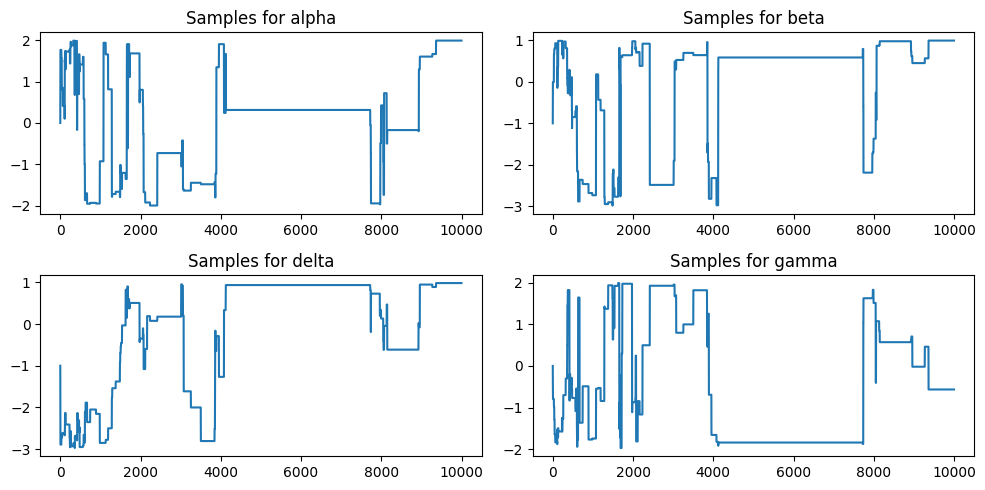

In [65]:
# Plot the results
plt.figure(figsize=(10, 5))
for i, param in enumerate(['alpha', 'beta', 'delta', 'gamma']):
    plt.subplot(2, 2, i + 1)
    plt.plot(mh_samples[:,i])
    plt.title(f'Samples for {param}')
    #plt.ylim((0,5))
plt.tight_layout()
plt.show()

In [55]:
log_likelihood_lv(jnp.array([mh_samples[0,:]]))

Array([-39.24921776], dtype=float64)

In [ ]:
q_means[16000,:]

IndexError: index 16000 is out of bounds for axis 0 with size 5000

In [50]:
log_likelihood_lv(jnp.array([q_means[-1,:]]))

Array([-14.78220119], dtype=float64)

In [39]:
np.shape(params_current)

(53, 4)

In [51]:

latent_dist = posterior.predict(jnp.array([q_means[-1,:]]), train_data=D)
predictive_dist = posterior.likelihood(latent_dist)
mf = predictive_dist.mean().reshape(-1,1)
vf = predictive_dist.stddev().reshape(-1,1)
mf

Array([[30.00968876]], dtype=float64)

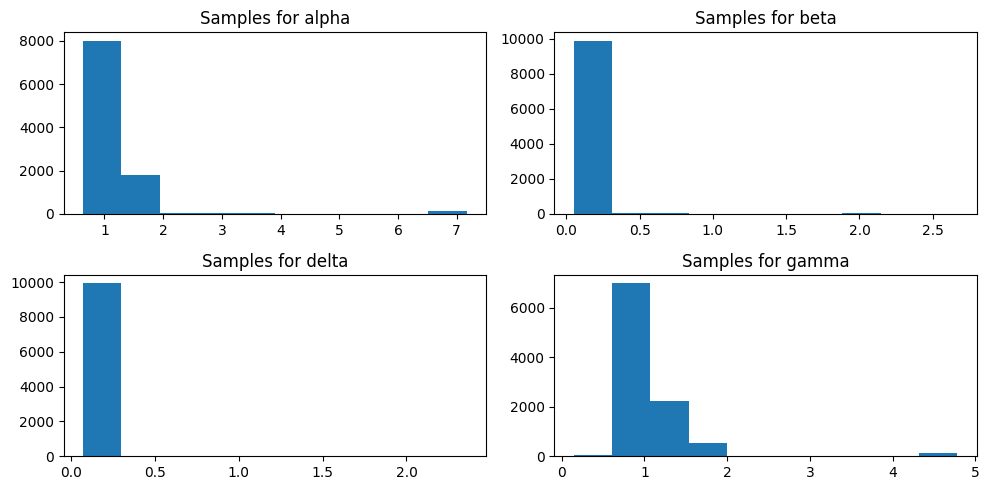

In [41]:
# Plot the results
plt.figure(figsize=(10, 5))
for i, param in enumerate(['alpha', 'beta', 'delta', 'gamma']):
    plt.subplot(2, 2, i + 1)
    plt.hist(jnp.exp(mh_samples[:,i]))
    plt.title(f'Samples for {param}')
    #plt.ylim((0,5))
plt.tight_layout()
plt.show()

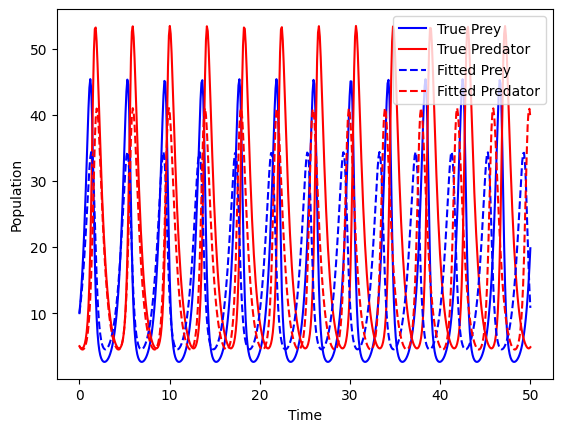

In [52]:
fitted_model = integrate_model(np.exp(q_means[-1,:]), t, initial_conditions)
#print(np.exp(best_params))
plt.figure()
plt.plot(t, data[:, 0], 'b-', label='True Prey')
plt.plot(t, data[:, 1], 'r-', label='True Predator')
plt.plot(t, fitted_model[:, 0], 'b--', label='Fitted Prey')
plt.plot(t, fitted_model[:, 1], 'r--', label='Fitted Predator')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Population')
plt.show()

In [ ]:
def lotka_volterra(X, t, alpha, beta, delta, gamma):
    x, y = X
    dxdt = alpha * x - beta * x * y
    dydt = delta * x * y - gamma * y
    return [dxdt, dydt]

# Vectorized integration function
def integrate_model(params, t, initial_conditions):
    alpha, beta, delta, gamma = params

    # Define the ODE function for a single set of parameters
    def odefunc(X, t):
        return lotka_volterra(X, t, alpha, beta, delta, gamma)

    # Integrate the ODE
    return odeint(odefunc, initial_conditions, t)

# Vectorized log-likelihood function
@jit
def log_likelihood_lve(params):#, t, data, initial_conditions):
    # Ensure params are in the correct shape (N, 4) where N is the number of parameter sets

    #params=jnp.exp(log_params)
    def integrate_single(params):
        return integrate_model(params, t, initial_conditions)
    # Vectorize integration over parameter sets
    models = vmap(integrate_single)(params)
    # Compute the error and log-likelihood for each parameter set
    errors = data - models
    sigma = 5000
    log_likelihoods = -jnp.sum(errors**2, axis=(1, 2)) / (2*sigma) + 10.
    return log_likelihoods

# Example data
true_params = jnp.array([2.0, 0.1,0.1,1.5])
initial_conditions = jnp.array([10.0, 5.0])
t = jnp.linspace(0, 50, 500)
data = integrate_model(true_params, t, initial_conditions)

# Initial guess for parameters
initial_params = jnp.array([[1.0, 0.05,1.0,0.1], [2.0, 0.1,2.0,0.1],[1.1,1.1,1.1,1.1]])

# Compute log-likelihoods for each parameter set
ll_values = log_likelihood_lve(initial_params)#, t, data, initial_conditions)
print("Log-Likelihoods:", ll_values)

Log-Likelihoods: [-330.55642959 -335.54976139  -40.39867634]


In [ ]:
np.random.seed(10)
N = 3000
mh_samples=np.zeros((N,4))
mh_samples[0] = np.array([0.25,-0.5,-0.5,0.15])
#mh_samples[0]=np.array([0.6, -0.6,  0.2,  0.1])
mh_samples[0] = np.array([1.9,0.2,0.2,1.4])#0.60, -2.20,  -2.20,  0.30
t_0 = 20
q_means=np.zeros((N,4))
q_means[0] = mh_samples[0]
q_cov = np.eye(4)*0.01#[0.1,0.01,0.01,0.1]
y_current=10**6
while np.abs(y_current)>10**5:
  params_current=jnp.array(np.random.multivariate_normal(mh_samples[0],q_cov,1))
  params_current=round(params_current,1)
  y_current = jnp.array(log_likelihood_lve(params_current).reshape(-1,1))


while np.shape(params_current)[0]<20:
  y_init=10**6
  while np.abs(y_init)>10**5:
    param_init=jnp.array(np.random.multivariate_normal(mh_samples[0],q_cov,1))
    param_init=round(param_init,1)
    y_init = log_likelihood_lve(param_init)
    #print(y_init)
  params_current = jnp.vstack([params_current, param_init])
  y_current = log_likelihood_lve(params_current).reshape(-1,1)
print(y_current)
#params_current=jnp.array(np.random.multivariate_normal(mh_samples[0],q_cov,20))
#params_current=round(params_current,1)
#y_current = jnp.array(log_likelihood_lve(params_current).reshape(-1,1))
epsilon = 0.1
obs_stddev=1e-3
proposal='normal'
D = gpx.Dataset(params_current, y=y_current)
#print(D)
posterior = fit_gp(params_current, y_current, key, do_optimize=True, obs_stddev=obs_stddev)
mini = jnp.array([0.00001,0.00001,0.0001,0.0001])
maxi=jnp.array([3,3,3,3])

'''# how many do you need to set up
x1_range = jnp.arange(start = -3., stop = 3., step = 1.0 )
x2_range = jnp.arange(start = -3., stop = 3., step = 1.0 )
x3_range = jnp.arange(start = -3., stop = 3., step = 1.0 )
x4_range = jnp.arange(start = -2., stop = 2., step = 1.0 )
x1_gridvalues, x2_gridvalues, x3_gridvalues,x4_gridvalues = jnp.meshgrid(x1_range, x2_range,x3_range,x4_range)
test_points = jnp.vstack([x1_gridvalues.flatten(), x2_gridvalues.flatten(), x3_gridvalues.flatten(), x4_gridvalues.flatten()]).T
'''
for i in range(1,N):
  # centred around prev step with var 1
  if i > t_0:
    q_cov=((i-2)/(i-1))*q_cov + ((2.4**2)/(4*(i-1)))*((i-1)*(np.outer(q_means[i-2],q_means[i-2]))-i*np.outer(q_means[i-1],q_means[i-1])+np.outer(mh_samples[i-1],mh_samples[i-1])+ 1e-9*np.eye(4))
  if proposal == 'uniform':
    params_prop = (np.random.uniform(0,1,4) - 0.5)*[0.1,0.1,0.1,0.1]*3.0 + mh_samples[i-1,:]
  else:
    params_prop=np.random.multivariate_normal(mh_samples[i-1],q_cov)
  u = np.random.uniform()


  params_now=mh_samples[i-1]
  # find mean and variance of log likelihood ratio at proposal and prev point
  m,v = gpmh_eval_posterior_wp(posterior,params_current,params_prop,params_now,key,obs_stddev,D,mini,maxi)

  print('step',i,'m',m,'v',v,log_epsilon_gamma(m,v,u),expected1(m,v),expected(m,v),jnp.log(epsilon),'Current',params_now,'proposed',params_prop,posterior.likelihood.obs_stddev**2)


  #generate test points if necessary
  if (expected(m,v) > epsilon):
    params_grid = jnp.vstack([params_now,params_prop])#.reshape(-1,1)
    #max=round(jnp.max(params_grid)+0.7,1)
    #min=round(jnp.min(params_grid)-0.7,1)
    max=round(jnp.minimum(jnp.max(params_grid)+0.7,maxi),1)
    min=round(jnp.maximum(jnp.min(params_grid)-0.7,mini),1)
    test_points = round(jnp.array(np.random.uniform(min,max,(1000,4))),1)
    test_points= remove_close_rows(test_points,params_current)
  npc=0
  while (expected(m,v) > epsilon) and np.size(test_points) >5 and npc<10:
  #while (log_epsilon_gamma(m,v,u) > jnp.log(epsilon)) and np.size(test_points) >5:
    test_points= remove_close_rows(test_points,params_current)

    #x_grid = jnp.arange(-5.0, 5.0, 0.01).reshape(-1, 1)
    #params_grid = jnp.vstack([params_now,params_prop])#.reshape(-1,1)
    #max=round(jnp.max(params_grid)+1.0,1)
    #min=round(jnp.min(params_grid)-1.0,1)

    #get lengthscale
    #ls = posterior.prior.kernel.lengthscale
    #print('lengthsxale:',ls)
    #test_points = jnp.arange(min-round(5*ls,1), round(ls*5,1), 0.1)
    #test_points = round(jnp.array(np.random.uniform(min,max,(100,4))),1)
    #test_points= remove_close_rows(test_points,params_current)
    #test_point_utilities = loss_2023paper(params_current, y_current, test_points,params_grid, key, obs_stddev)
    test_point_utilities = loss_2023papernew(posterior,params_current, y_current, test_points,params_grid, key, obs_stddev)

    j = jnp.argmax(jnp.array(test_point_utilities))
    params_new = test_points[j]

    y_new = log_likelihood_lve(jnp.array([params_new]))

    npc+=1
    while np.isnan(y_new) or np.abs(y_new)>10**5:
      test_points=jnp.delete(test_points,j,axis=0)
      test_point_utilities = loss_2023papernew(posterior,params_current, y_current, test_points,params_grid, key, obs_stddev)
      j = jnp.argmax(jnp.array(test_point_utilities))
      params_new = test_points[j]
      y_new = log_likelihood_lve(jnp.array([params_new]))
      npc+=1
      if npc > 10:
        break
    if npc > 10:
      break
    params_current = jnp.vstack([params_current, params_new])
    y_current = log_likelihood_lve(params_current).reshape(-1,1)
    D = gpx.Dataset(params_current, y_current)

    posterior = fit_gp(params_current, y_current, key, do_optimize=True, obs_stddev=obs_stddev)
    m,v = gpmh_eval_posterior_wp(posterior,params_current,params_prop,params_now,key,obs_stddev, D,mini,maxi)
    print('chosen new point',params_new,'size',np.shape(params_current),jnp.exp(expected1(m,v)),expected(m,v),epsilon_gamma(m,v,u))
  print('m',m,'v',v,u)
  if m >= jnp.log(u):
    mh_samples[i] = params_prop
  else:
    mh_samples[i] = mh_samples[i-1]

  q_means[i] = q_means[i-1] + (mh_samples[i]-q_means[i-1])/(i+1)

[[-15.40861403]
 [-24.72256635]
 [-28.23390091]
 [-26.50720311]
 [-27.18096241]
 [-26.47312728]
 [-16.25725331]
 [-24.3982058 ]
 [-21.5955133 ]
 [-17.96698006]
 [-27.75548408]
 [-24.56535027]
 [-24.73770185]
 [-32.04137756]
 [-32.04137756]
 [-25.01180924]
 [-25.11156988]
 [-25.54198037]
 [-21.56931863]
 [-23.97852204]]


  0%|          | 0/1000 [00:00<?, ?it/s]

step 1 m [36.37276142] v [[0.08315677]] [[-1096.53177289]] -672.4918160453188 [[0.]] -2.3025850929940455 Current [1.9 0.2 0.2 1.4] proposed [1.91174757 0.00925431 0.10770907 1.44697514] 1.013896356132483e-06
m [36.37276142] v [[0.08315677]] 0.05047767015399762
step 2 m -100000.0 v [[0.2142632]] [[-4.99993858e+09]] -4999352847.246474 [[0.]] -2.3025850929940455 Current [1.91174757 0.00925431 0.10770907 1.44697514] proposed [ 1.83679855 -0.02175977 -0.01625899  1.38762726] 1.013896356132483e-06
m -100000.0 v [[0.2142632]] 0.7524961702186028
step 3 m -100000.0 v [[0.15820681]] [[-4.99951904e+09]] -4999246875.303174 [[0.]] -2.3025850929940455 Current [1.91174757 0.00925431 0.10770907 1.44697514] proposed [ 1.94104164 -0.03782641  0.34814163  1.37303947] 1.013896356132483e-06
m -100000.0 v [[0.15820681]] 0.14762019228529766
step 4 m -100000.0 v [[0.34372524]] [[-4.99983561e+09]] -4999489053.269906 [[0.]] -2.3025850929940455 Current [1.91174757 0.00925431 0.10770907 1.44697514] proposed [ 1.9

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [1.9 0.5 0.2 1.7] size (21, 4) 0.1926242187528479 [[1.46795482e-09]] [[0.02640273]]
m [1.11160552] v [[0.04302165]] 0.8427384994497643
step 41 m -100000.0 v [[0.27863008]] [[-4.99997743e+09]] -4999432498.311724 [[0.]] -2.3025850929940455 Current [1.93849639 0.0519798  0.00737535 1.28989109] proposed [ 1.80365537 -0.01621989 -0.05996205  1.27016967] 1.013896356132483e-06
m -100000.0 v [[0.27863008]] 0.8876242492845323
step 42 m [-32.51703973] v [[0.11092045]] [[-382.26221958]] -280.7237906866608 [[2.08253102e-15]] -2.3025850929940455 Current [1.93849639 0.0519798  0.00737535 1.28989109] proposed [1.99158837 0.18507897 0.01516758 1.29727589] 1.013896356132483e-06
m [-32.51703973] v [[0.11092045]] 0.18785459106952418
step 43 m [-22.63610475] v [[0.06088882]] [[-217.31121854]] -58.35833239639268 [[2.96692023e-11]] -2.3025850929940455 Current [1.93849639 0.0519798  0.00737535 1.28989109] proposed [1.88027306 0.00637434 0.09253639 1.30927597] 1.013896356132483e-06
m [-22.636

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [2.1 0.1 0.3 1.4] size (22, 4) 1.0639334174233784e-78 [[5.14237548e-11]] [[7.07261787e-90]]
m [-23.21642876] v [[0.44885678]] 0.12129139231336594
step 129 m -100000.0 v [[0.47138344]] [[-4.99982814e+09]] -4999563691.182504 [[0.]] -2.3025850929940455 Current [2.24760133 0.01210037 0.13429969 1.33919002] proposed [ 2.10388447  0.06271131 -0.02572014  1.45164468] 1.013896356132483e-06
m -100000.0 v [[0.47138344]] 0.3072584463561113
step 130 m -100000.0 v [[0.02515523]] [[-4.99922919e+09]] -4998111378.308441 [[0.]] -2.3025850929940455 Current [2.24760133 0.01210037 0.13429969 1.33919002] proposed [ 2.26522511 -0.01918292  0.14315055  1.3651653 ] 1.013896356132483e-06
m -100000.0 v [[0.02515523]] 0.2944644312990399
step 131 m [-77.48945576] v [[0.35642565]] [[-2877.60213503]] -2631.2684359960817 [[1.19367298e-34]] -2.3025850929940455 Current [2.24760133 0.01210037 0.13429969 1.33919002] proposed [2.33615164 0.00265619 0.28943345 1.44168862] 1.013896356132483e-06
m [-77.4894

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [2.1 0.4 0.5 1.2] size (23, 4) 0.03553174476645576 [[6.30172923e-18]] [[3.84449535e-05]]
m [1.88701523] v [[0.05400371]] 0.6185882488017116
step 1489 m [-30.35223692] v [[0.09961195]] [[-304.30611081]] -221.53859036907548 [[1.71298997e-14]] -2.3025850929940455 Current [2.20508126 0.00503617 0.00335718 1.29421364] proposed [2.2576552  0.01685627 0.08111274 1.31508614] 1.013896356132483e-06
m [-30.35223692] v [[0.09961195]] 0.15782785403567268
step 1490 m [-8.170851] v [[0.01423499]] [[-22.60145355]] -0.3798275694107154 [[2.70473562e-05]] -2.3025850929940455 Current [2.20508126 0.00503617 0.00335718 1.29421364] proposed [2.18245167 0.0051285  0.02889241 1.28957949] 1.013896356132483e-06
m [-8.170851] v [[0.01423499]] 0.7995484947130731
step 1491 m -100000.0 v [[0.31269739]] [[-4.9999401e+09]] -4999464303.0727415 [[0.]] -2.3025850929940455 Current [2.20508126 0.00503617 0.00335718 1.29421364] proposed [ 2.35097755 -0.03734693 -0.01963905  1.25549531] 1.013896356132483e-06

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [1.8 0.2 0.1 1.1] size (24, 4) 2.326087470606911 [[0.05358405]] [[2.5885036e-28]]
m [-1.16306956] v [[0.04481524]] 0.07660667922506537
step 2101 m -100000.0 v [[0.18700902]] [[-4.99905649e+09]] -4999307294.102355 [[0.]] -2.3025850929940455 Current [2.19831315e+00 1.58342560e-03 1.02029895e-02 1.31616860e+00] proposed [ 2.0839341  -0.01066416 -0.00317922  1.36832889] 1.013896356132483e-06
m -100000.0 v [[0.18700902]] 0.016900216434148185
step 2102 m -100000.0 v [[0.01475617]] [[-4.99971983e+09]] -4997534185.067797 [[0.]] -2.3025850929940455 Current [2.19831315e+00 1.58342560e-03 1.02029895e-02 1.31616860e+00] proposed [ 2.21539518 -0.02003998  0.01160743  1.29640057] 1.013896356132483e-06
m -100000.0 v [[0.01475617]] 0.7115158489535662
step 2103 m -100000.0 v [[0.03120828]] [[-4.99980573e+09]] -4998304381.732624 [[0.]] -2.3025850929940455 Current [2.19831315e+00 1.58342560e-03 1.02029895e-02 1.31616860e+00] proposed [ 2.19948046e+00  2.05090961e-02 -1.86105056e-03  1.27

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [2.  0.1 0.2 1.2] size (25, 4) 2.0753877104094025 [[0.01787889]] [[0.05759331]]
m [-2.24530747] v [[0.04349498]] 0.869590783830618
step 2188 m -100000.0 v [[0.06856942]] [[-4.99997858e+09]] -4998856046.976896 [[0.]] -2.3025850929940455 Current [2.25591088 0.00247359 0.01176388 1.35198103] proposed [ 2.32762778e+00 -2.11347858e-03  1.06662864e-03  1.34377572e+00] 1.013896356132483e-06
m -100000.0 v [[0.06856942]] 0.9454116362542226
step 2189 m [-4.1653598] v [[0.01451287]] [[-13.09056153]] 0.1732435628205259 [[0.00149943]] -2.3025850929940455 Current [2.25591088 0.00247359 0.01176388 1.35198103] proposed [2.28203072 0.00419947 0.02414975 1.36981347] 1.013896356132483e-06
m [-4.1653598] v [[0.01451287]] 0.3476595149859635
step 2190 m -100000.0 v [[0.20573065]] [[-4.99982612e+09]] -4999339563.637018 [[0.]] -2.3025850929940455 Current [2.25591088 0.00247359 0.01176388 1.35198103] proposed [ 2.37386199 -0.02890563 -0.01596177  1.38163658] 1.013896356132483e-06
m -100000.0 v

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [2.4 0.1 0.1 1.4] size (26, 4) 8.954904371832133e-17 [[0.]] [[4.50985154e-17]]
m [7.90246649] v [[0.02294923]] 0.939129568097616
step 2556 m -100000.0 v [[0.02298486]] [[-4.99889578e+09]] -4998024229.8316965 [[0.]] -2.3025850929940455 Current [2.213346   0.00282607 0.00723884 1.43816248] proposed [ 2.20106717 -0.01028057 -0.02364053  1.41205994] 1.013896356132483e-06
m -100000.0 v [[0.02298486]] 0.1874587444568674
step 2557 m [-28.00846735] v [[0.13822804]] [[-300.1034316]] -202.93355112102722 [[2.13018669e-13]] -2.3025850929940455 Current [2.213346   0.00282607 0.00723884 1.43816248] proposed [2.19262112 0.00855003 0.05719124 1.53518616] 1.013896356132483e-06
m [-28.00846735] v [[0.13822804]] 0.2547775342030414
step 2558 m -100000.0 v [[0.02209471]] [[-4.99973973e+09]] -4997984826.703811 [[0.]] -2.3025850929940455 Current [2.213346   0.00282607 0.00723884 1.43816248] proposed [ 2.1955245   0.01162432 -0.00982608  1.40133778] 1.013896356132483e-06
m -100000.0 v [[0.022

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point [2.5 0.1 0.1 1.2] size (27, 4) 2.1489201383109235 [[0.03071478]] [[0.00345939]]
m [-1.62404616] v [[0.03720974]] 0.4342037404964295
step 2568 m -100000.0 v [[0.09566081]] [[-4.99958219e+09]] -4999031478.297293 [[0.]] -2.3025850929940455 Current [2.213346   0.00282607 0.00723884 1.43816248] proposed [ 2.21540219e+00  1.00920754e-03 -9.87890335e-03  1.34040672e+00] 1.013896356132483e-06
m -100000.0 v [[0.09566081]] 0.2746353149845563
step 2569 m -100000.0 v [[0.04462376]] [[-4.99917072e+09]] -4998581970.418264 [[0.]] -2.3025850929940455 Current [2.213346   0.00282607 0.00723884 1.43816248] proposed [ 2.17767583e+00  1.84475795e-03 -1.51612555e-02  1.37890729e+00] 1.013896356132483e-06
m -100000.0 v [[0.04462376]] 0.17344343529786177
step 2570 m -100000.0 v [[0.05018801]] [[-4.99988187e+09]] -4998662881.3699255 [[0.]] -2.3025850929940455 Current [2.213346   0.00282607 0.00723884 1.43816248] proposed [ 2.26695427e+00 -1.29700640e-02  2.17568312e-03  1.38189003e+00] 1.01389

In [ ]:
latent_dist = posterior.predict(jnp.array([[1,0.1,0.1,1]]), train_data=D)
predictive_dist = posterior.likelihood(latent_dist)
mf = predictive_dist.mean().reshape(-1,1)
vf = predictive_dist.stddev().reshape(-1,1)
mf

Array([[nan]], dtype=float64)

In [ ]:
y_current

Array([[-2.56723956e+84],
       [-1.54086140e+01],
       [-2.47225663e+01],
       [-2.82339009e+01],
       [-2.65072031e+01],
       [           -inf],
       [-2.71809624e+01],
       [-2.64731273e+01],
       [-1.62572533e+01],
       [-2.43982058e+01],
       [-2.15955133e+01],
       [-1.79669801e+01],
       [-2.77554841e+01],
       [-2.45653503e+01],
       [-2.47377018e+01],
       [-3.20413776e+01],
       [-3.20413776e+01],
       [-2.50118092e+01],
       [-2.51115699e+01],
       [-2.55419804e+01]], dtype=float64)

In [ ]:
np.random.seed(10)
N = 1000
mh_samples=np.zeros((N,4))
mh_samples[0] = np.array([0.25,-0.5,-0.5,0.15])
#mh_samples[0]=np.array([0.6, -0.6,  0.2,  0.1])
mh_samples[0] = np.array([1.9,0.3,0.3,1.9])#0.60, -2.20,  -2.20,  0.30
t_0 = 30
q_means=np.zeros((N,4))
q_means[0] = mh_samples[0]
q_cov = np.eye(4)*0.01#[0.1,0.01,0.01,0.1]
y_current=10**6
while np.abs(y_current)>10**5:
  params_current=jnp.array(np.random.multivariate_normal(mh_samples[0],q_cov,1))
  params_current=round(params_current,1)
  y_current = jnp.array(log_likelihood_lve(params_current).reshape(-1,1))


while np.shape(params_current)[0]<20:
  y_init=10**6
  while np.abs(y_init)>10**5:
    param_init=jnp.array(np.random.multivariate_normal(mh_samples[0],q_cov,1))
    param_init=round(param_init,1)
    y_init = log_likelihood_lve(param_init)
    print(y_init)
  params_current = jnp.vstack([params_current, param_init])
  y_current = log_likelihood_lve(params_current).reshape(-1,1)

[-24.5587771]
[-25.6092774]
[-28.89576391]
[-29.75623397]
[-29.55147403]
[-29.35636794]
[-28.77113438]
[-28.14038479]
[-30.1946534]
[-22.8227922]
[-26.71053706]
[-25.6325494]
[-31.00947374]
[-27.78685659]
[-27.98442845]
[-27.98442845]
[-26.73427641]
[-27.77584153]
[-26.57312417]


## Lotka Volterra

In [ ]:
# what is the lotka-volterra likelihood
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define the Lotka-Volterra equations
def lotka_volterra(X, t, alpha, beta, delta, gamma):
    x, y = X
    dxdt = alpha * x - beta * x * y
    dydt = delta * x * y - gamma * y
    return [dxdt, dydt]

# Generate synthetic data using known parameters
def generate_synthetic_data(true_params, initial_conditions, t):
    return odeint(lotka_volterra, initial_conditions, t, args=tuple(true_params))

# Define the likelihood function
def log_likelihood(log_params, t, data, initial_conditions):
    params=np.exp(log_params)
    alpha, beta, delta, gamma = params
    model = odeint(lotka_volterra, initial_conditions, t, args=(alpha, beta, delta, gamma))
    error = data - model
    return -np.sum(error**2) / 2

# Define the Metropolis-Hastings algorithm
def metropolis_hastings(log_likelihood, initial_params, t, data, initial_conditions, n_iterations, proposal_width):
    params = np.array(initial_params)
    log_likelihood_current = log_likelihood(params, t, data, initial_conditions)
    samples = [params]

    for i in range(n_iterations):
        # Propose new parameters
        params_new = params + (np.random.uniform(0,1, size=params.shape)-0.5)*proposal_width
        log_likelihood_new = log_likelihood(params_new, t, data, initial_conditions)

        # Acceptance criterion
        if np.random.rand() < np.exp(log_likelihood_new - log_likelihood_current):
            params = params_new
            log_likelihood_current = log_likelihood_new

        print(i)
        samples.append(params)

    return np.array(samples)




In [ ]:
# True parameters for generating synthetic data
true_params = [2.0, 0.1, 0.1, 1.5]
initial_conditions = [10, 5]
t = np.linspace(0, 50, 500)
data = generate_synthetic_data(true_params, initial_conditions, t)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


<ipython-input-6-9d0be5314d05>:37: RuntimeWarning: overflow encountered in exp
  if np.random.rand() < np.exp(log_likelihood_new - log_likelihood_current):


Streaming output truncated to the last 5000 lines.
5000
5001
5002
5003
5004
5005
5006
5007
5008
5009
5010
5011
5012
5013
5014
5015
5016
5017
5018
5019
5020
5021
5022
5023
5024
5025
5026
5027
5028
5029
5030
5031
5032
5033
5034
5035
5036
5037
5038
5039
5040
5041
5042
5043
5044
5045
5046
5047
5048
5049
5050
5051
5052
5053
5054
5055
5056
5057
5058
5059
5060
5061
5062
5063
5064
5065
5066
5067
5068
5069
5070
5071
5072
5073
5074
5075
5076
5077
5078
5079
5080
5081
5082
5083
5084
5085
5086
5087
5088
5089
5090
5091
5092
5093
5094
5095
5096
5097
5098
5099
5100
5101
5102
5103
5104
5105
5106
5107
5108
5109
5110
5111
5112
5113
5114
5115
5116
5117
5118
5119
5120
5121
5122
5123
5124
5125
5126
5127
5128
5129
5130
5131
5132
5133
5134
5135
5136
5137
5138
5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189

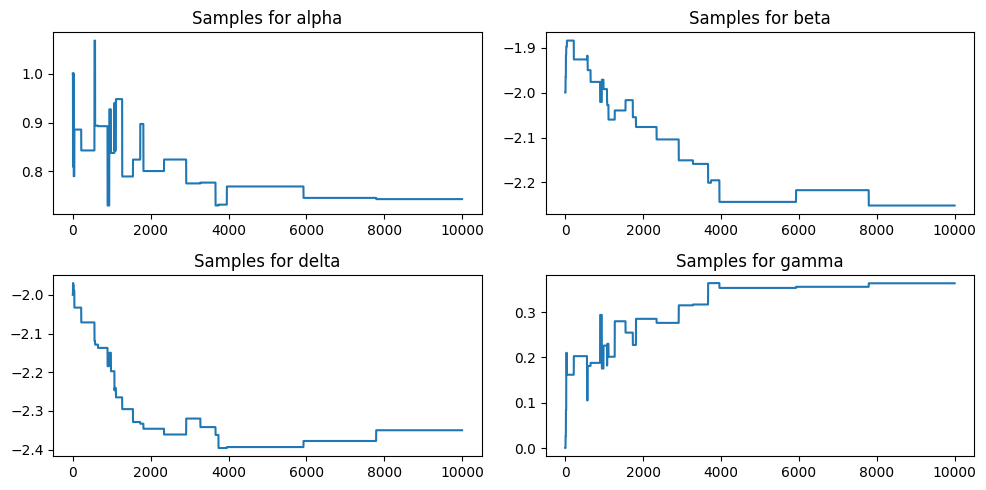

[2.10322658 0.10525787 0.09539323 1.43897243]


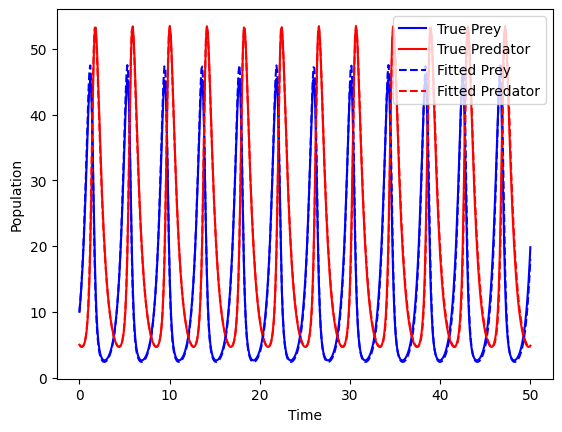

In [ ]:


# Initial guess for parameters
initial_params = [1.0, -2.0, -2.0, 0.0]
n_iterations = 10000
proposal_width = [0.5,0.1,0.1,0.5]

# Run the Metropolis-Hastings algorithm
samples = metropolis_hastings(log_likelihood, initial_params, t, data, initial_conditions, n_iterations, proposal_width)

# Plot the results
plt.figure(figsize=(10, 5))
for i, param in enumerate(['alpha', 'beta', 'delta', 'gamma']):
    plt.subplot(2, 2, i + 1)
    plt.plot(samples[:, i])
    plt.title(f'Samples for {param}')
plt.tight_layout()
plt.show()

# Plot the fitted model vs true data
best_params = samples[np.argmax([log_likelihood(p, t, data, initial_conditions) for p in samples])]
fitted_model = generate_synthetic_data(np.exp(best_params), initial_conditions, t)
print(np.exp(best_params))
plt.figure()
plt.plot(t, data[:, 0], 'b-', label='True Prey')
plt.plot(t, data[:, 1], 'r-', label='True Predator')
plt.plot(t, fitted_model[:, 0], 'b--', label='Fitted Prey')
plt.plot(t, fitted_model[:, 1], 'r--', label='Fitted Predator')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Population')
plt.show()
